# Profiling with PyTorch

In [1]:

import os
from typing import Sequence, Tuple
from datetime import datetime
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchmetrics.functional as metrics
import numpy as np
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline


use_cuda = torch.cuda.is_available()
print(f"CUDA is {'' if use_cuda else 'not '}available")
device = torch.device("cuda" if use_cuda else "cpu")

CUDA is available


In [17]:
TUTORIAL_PATH = "/mnt/lustre-emmy-ssd/projects/isc2024_accel_genai_pytorch/isc2024-tutorial/profiling-tutorial"
DATA_PATH = f"{TUTORIAL_PATH}/data"

## What is profiling?

According to [wikipedia](https://en.wikipedia.org/wiki/Profiling_(computer_programming)): 

"Profiling is a form of dynamic program analysis that measures, for example, the space (memory) or time complexity of a program, the usage of particular instructions, or the frequency and duration of function calls. Most commonly, profiling information serves to aid program optimization, and more specifically, performance engineering."

What this means is that you analyse your program, trying to identify bottlenecks, and thereby optimizing it's execution. As an example, you might have an application needs to read a lot of input data (quite typical in machine learning!) during its run. A profile might show you that while your code runs, your processor is mostly idling since it is waiting for input data. This might give you a hint on how to optimize your program: maybe you can read in _part_ of the input, and already start computing on that _while_ you're loading in your next samples. Or: maybe you can copy your data to a faster disk, before you start running.

## Why should I care about profiling?

You may know that training large models like GPT-3 takes several _million_ dollars [source](https://lambdalabs.com/blog/demystifying-gpt-3/) and a few hundred MWh [source](https://www.theregister.com/2020/11/04/gpt3_carbon_footprint_estimate/). If the engineers that trained these models did _not_ spend time on optimization, it might have been several million dollars and hunderds of MWh more.

Sure, the model you'd like to train is probably not quite as big. But maybe you want to train it 10000 times, because you want to do hyperparameter optimization. And even if you only train it once, it may take quite a bit of compute resources, i.e. money and energy.

## When should I care about profiling?

Well, you should _always_ care if your code runs efficiently, but there's different levels of caring.

From personal experience: if I know I'm going to run a code only once, for a few days, on a single GPU, I'll probably not create a full profile. What I _would_ do is inspect my GPU and CPU utilization during my runs, just to see if it is _somewhat_ efficient, and if I didn't make any obvious mistakes (e.g. accidentally _not_ using the GPU, even if I have one available).

If I know that I'll run my code on multiple GPUs, for multiple days, (potentially) on multiple nodes, and/or I need to run it multiple times, I know that my resource footprint is going to be large, and it's worth spending some time and effort to optimize the code. That's when I'll create a profile. The good part is: the more often you do it, the quicker and more adapt you become at it.

# Define the necessary functions of code

First, we will define the necessary functions to run the training. That means we define
- A model (as a class deriving from nn.Module)
- Some code to plot the accuracy / loss curves
- Some code to set the device on which we want to execute
- A train & test loop (this time with some profiling code)

### Define model

In [9]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 4 convolution layers, with a non-linear activation after each.
        # maxpooling after the activations of the 2nd, 3rd, and 4th conv layers
        # 2 dense layers for classification
        # log_softmax
        #
        # As for the number of channels of each layers, try to experiment!

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # in_features of the first layer should be the product of the output shape of your feature extractor!
        # E.g. if the output of your feature extractor has size (batch x 128 x 4 x 4), in_features = 128*4*4=2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=10),
            nn.LogSoftmax(dim=1)
        )



    def forward(self, x):
        features = self.feature_extractor(x)
        
        return self.classifier(features)


### Define function for plotting metric curves

In [11]:
def plot_metric_curve(
    train_metric: Sequence[float], 
    val_metric: Sequence[float],
    n_epochs: int,
    metric_name: str, # Label of the y-axis, e.g. 'Accuracy'
    x_axis_name: str = 'Epoch'
):
    # create values for the x-axis
    train_steps, val_steps = map(
        lambda metric_values: np.linspace(start=0, stop=n_epochs, num=len(metric_values)),
        (train_metric, val_metric)
    )
    
    plt.plot(train_steps, train_metric, label='train')
    plt.plot(val_steps, val_metric, label='validation')
    plt.title(f"{metric_name} vs. {x_axis_name}")
    plt.legend()
    plt.show()

### Define train and test loop
The `train(...)` function is just for reference: this is the same train function you used in the CIFAR10 hands-on earlier. Then, we define the `train_profiling(...)` function, which is essentially the same training loop, but with the necessary code added to generate the profiles. Finally, we specify the `test(...)` function. This is the same as from the CIFAR10 hands-on earlier, but note that in theory we could also profile the testing part. Usually, training takes by far the most time, and is therefore the most important to optimize. There are exceptions however, e.g. if you use certain metrics that are very heavy to compute, and you want to compute those on a large test dataset. In that case, optimizing the test loop might make sense as well.

In [8]:
# This is the actual train loop we will use for profiling
def train_profiling(model, device, train_loader, optimizer, epoch, log_interval, logdir):
    model.train()
    
    WAIT, WARMUP, ACTIVE, REPEAT = 10, 10, 5, 2

    # Create a torch.profiler.profile object, and call it as the last part of the training loop
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA
        ],
        schedule=torch.profiler.schedule(
            wait=WAIT,
            warmup=WARMUP,
            active=ACTIVE,
            repeat=REPEAT
        ),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(logdir, worker_name='worker0'),
        record_shapes=True,
        profile_memory=True,  # This will take 1 to 2 minutes. Setting it to False could greatly speedup.
        with_stack=True
    ) as p:
        for batch_idx, (data, target) in enumerate(train_loader):
            # move data and target to the gpu, if available and used
            data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))
            
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        
            accuracy = metrics.accuracy(output, target, task='multiclass', num_classes=10)
        
            if batch_idx % log_interval == 0:
                print(
                    f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100 * batch_idx / len(train_loader):.0f}%)]'
                    f'\tLoss: {loss.detach().item():.6f}'
                    f'\tAccuracy: {accuracy.detach().item():.2f}'
                )

            yield loss.detach().item(), accuracy.detach().item() 
            
            p.step()
            
            # Allow to break early for the purpose of shorter profiling
            if batch_idx == (WAIT + WARMUP + ACTIVE) * REPEAT:
                break

# Note that the test loop is decorated
# with the @torch.no_grad() decorator. This tells PyTorch that it doesn't need to compute gradients
# in the test loops, as those are not needed. This will speed up execution.
@torch.no_grad()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        # move data and target to the gpu, if available and used
        data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))

        # get model output
        output = model(data)

        # calculate loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

        # get most likely class label
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # count the number of correct predictions
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))
    
    yield test_loss, correct / len(test_loader.dataset)

### Specify the fitting function

Here, we combine the functions we defined above into a single function that will take care of the training, validation, loop over multiple epochs, and finally plot the results. Note that we call the `train_profiling` function from here, which is the one that will generate the profile.

In [7]:
def fit_profiling(model, optimizer, n_epochs, device, train_loader, test_loader, log_interval, logdir):

    # get the validation loss and accuracy of the untrained model
    start_val_loss, start_val_acc = tuple(test(model, device, test_loader))[0]

    # don't mind the following train/test loop logic too much, if you want to know what's happening, let us know :)
    # normally you would pass a logger to your train/test loops and log the respective metrics there
    (train_loss, train_acc), (val_loss, val_acc) = map(lambda arr: np.asarray(arr).transpose(2,0,1), zip(*[
        (
            [*train_profiling(model, device, train_loader, optimizer, epoch, log_interval, logdir)],
            [*test(model, device, test_loader)]
        )
        for epoch in range(n_epochs)
    ]))

    # flatten the arrays
    train_loss, train_acc, val_loss, val_acc = map(np.ravel, (train_loss, train_acc, val_loss, val_acc))

    # prepend the validation loss and accuracy of the untrained model
    val_loss, val_acc = (start_val_loss, *val_loss), (start_val_acc, *val_acc)

    plot_metric_curve(train_loss, val_loss, n_epochs, 'Loss')
    plot_metric_curve(train_acc, val_acc, n_epochs, 'Accuracy')

### Defining a custom dataloader
One of the things we learn in this profiling tutorial is the importance of an efficient data I/O pipeline. We start here with a simple custom PyTorch Dataset. This Dataset can read individual `*.png` images from a directory, and can be passed a single `*.pkl` file with all the labels in a dictionary that is indexed by the filenames of the image files (so that we know which label belongs to which image).

In [27]:
import pickle
import glob
from torchvision.io import read_image
from PIL import Image
        
class Cifar10PNGDataset(Dataset):
    def __init__(self, label_file, img_dir, transform=None, target_transform=None):
        # Load labels
        with open(label_filename, 'rb') as fo:
            self.label_dict = pickle.load(fo, encoding='bytes')
        # List filenames with png extension
        self.img_filenames = glob.glob(os.path.join(img_dir, '*.png'))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label_dict)
    
    def __getitem__(self, idx):
        # Get filename with index idx:
        img_filename = self.img_filenames[idx]
        # Read file from disk
        # image = read_image(img_filename)
        image = Image.open(img_filename)
        # Read label from label dictionary
        label = self.label_dict[os.path.basename(img_filename)]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Let's check that our dataloader actually works. It should show an image and its corresponding label. You can change the `sample_idx` to check different samples

In [28]:
PNG_DATA = os.path.join(DATA_PATH, 'cifar10_png')
label_filename = os.path.join(DATA_PATH, "labels.pkl")
train_dataset = Cifar10PNGDataset(label_file=label_filename, img_dir=PNG_DATA)

# Inspect one image and one label as example:
sample_idx = 0
img_sample = train_dataset[sample_idx][0]
label_sample = train_dataset[sample_idx][1]

#plt.imshow(img_sample.permute(1,2,0))
plt.imshow(img_sample)
print(f"Label: {label_sample}")
print(f"(0 = airplane, 1 = automobile, 2 = bird, 3 = cat, 4 = deer, 5 = dog, 6 = frog, 7 = horse, 8 = ship, 9 = truck)")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/lustre-emmy-ssd/projects/isc2024_accel_genai_pytorch/isc2024-tutorial/profiling-tutorial/data/labels.pkl'

Let's also define a helper function to easily get the train and test dataloaders

In [ ]:
def get_dataloaders(batch_size, num_workers, transform):    
    PNG_DATA, label_filename = (
        os.path.join(DATA_PATH, 'cifar10_png'),
        os.path.join(DATA_PATH, "labels.pkl")
    )

    # arguments which are the same for both the train and test dataloaders
    dataloader = partial(
        torch.utils.data.DataLoader,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=use_cuda,
    )
    
    train_loader = dataloader(
        Cifar10PNGDataset(img_dir=PNG_DATA, label_file=label_filename, transform=transform),
        shuffle=True
    )
    
    test_loader = dataloader(
        datasets.CIFAR10(DATA_PATH, train=False, transform=transform, download=True),
        shuffle=False
    )
    
    return train_loader, test_loader

# Creating the profile
To create the profile, we now run a single epoch of the training

In [10]:
BATCH_SIZE = 256
EPOCHS = 1
LEARNING_RATE = 1e-4
NUM_DATALOADER_WORKERS = 0

LOGGING_INTERVAL = 10  # Controls how often we print the progress bar

model = CIFAR10CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)

transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize the data to 0 mean and 1 standard deviation, now for all channels of RGB
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

## You can also try this, and see how bad it is:
# train_loader, test_loader = get_dataloaders(
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_DATALOADER_WORKERS,
#     transform=transform
# )

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=train,
        num_workers=NUM_DATALOADER_WORKERS
    )
    for train in (True, False)
)


logdir = "logs/baseline/" + datetime.now().strftime("%Y%m%d-%H%M%S")

fit_profiling(model, optimizer, EPOCHS, device, train_loader, test_loader, LOGGING_INTERVAL, logdir)

Files already downloaded and verified
Files already downloaded and verified

Test set: Average loss: 2.3030, Accuracy: 1000/10000 (10%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.301343	Accuracy: 0.13
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.286962	Accuracy: 0.12
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.240544	Accuracy: 0.25


STAGE:2024-05-07 16:47:22 1652865:1652865 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-07 16:47:24 1652865:1652865 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-07 16:47:24 1652865:1652865 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.179579	Accuracy: 0.20
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.051930	Accuracy: 0.27


STAGE:2024-05-07 16:47:37 1652865:1652865 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-07 16:47:38 1652865:1652865 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-07 16:47:38 1652865:1652865 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.908519	Accuracy: 0.32

Test set: Average loss: 1.9555, Accuracy: 3085/10000 (31%)



NameError: name 'plot_metric_curve' is not defined

# Inspect the profile

Now that we have generated a profile, we want to inspect it. For that, we will start a TensorBoard session in the cell below. It will give you a link to the running tensorboard instance.

If, for some reason, you were not able to generated the logs yourself, you can uncomment the line `logdir = ...` and inspect a reference profile that we generated for you.

WARNING: profiles (so called 'trace files') contain a lot of data. It may take a while (up to a minute or so) before the TensorBoard interface actually displays the data. 

# Understanding the profiler output

### Views
In the first fiew, you see an overview of the profiling. This is probably the display that will provide the most actionable insights. What do we see? [This blog](https://pytorch.org/blog/pytorch-profiler-1.9-released/) contains a very detailed explaination. Below, we will cover the basics, but if you are going to profile your own code, the blog may prove very useful to get the most out of the profiler output.

### Step Time Breakdown
Let's start with the central part, the Step Time Breakdown.

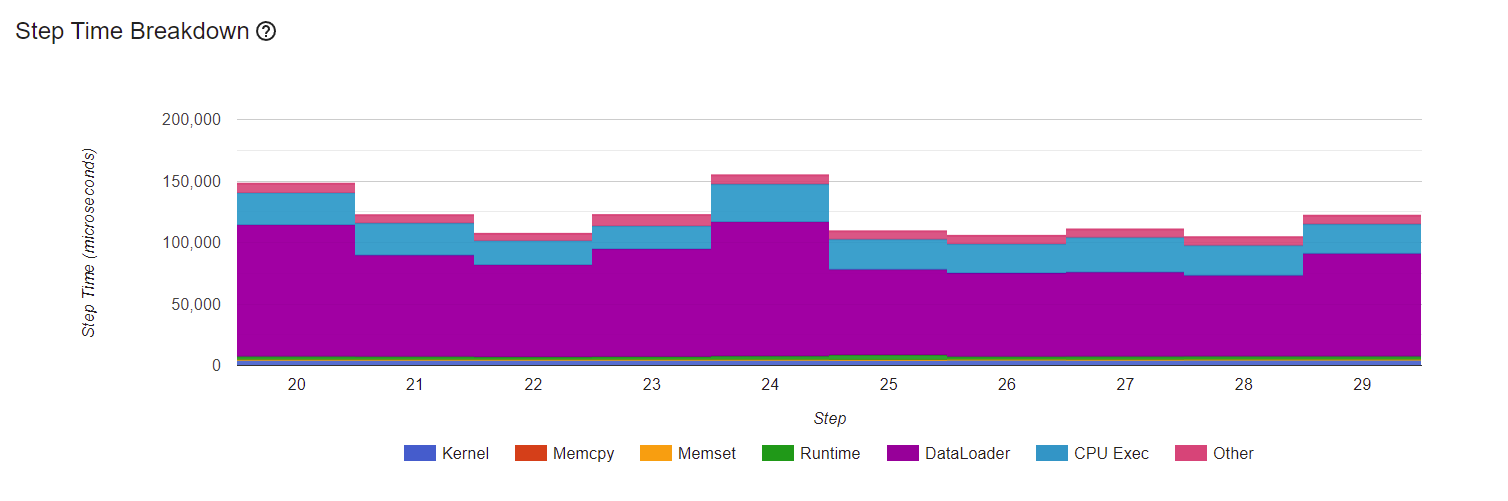

Here, we see how long each 'Step' took, and what that time was spent on. A 'Step' is a single training step, i.e. a forward and backeward pass on a single batch. If you look carefully at the `train_profiling(...)` code, and in particular the `torch.profiler.profile` call we did there, you see that we passed `wait=10, warmup=10, active=10` as arguments. What that means is, it waits for the first 10 steps (i.e. step 0-9), then, the profiler gets activated, but discards it results (for step 10-19), and then 10 steps get recorded (i.e. step 20-29). This cycle will keep repeating itself as long as we were training. With a batch size of 128 and 50000 images in total, the cycle would normally be repeated 13 times if we trained for one epoch. The PyTorch profiler calls each of these cycles a 'Span'. In this case however, we cut the training shorter for faster profiling, and only trained for 60 iterations. Thus, we'll only see two spans in our profile. Thus, this cycle repeated 13 times. 

### Spans
Click the 'Spans' button. Here, you see that indeed, we recorded 2 'spans'. If you click on span 2, you'll see that this contains the timing for step 50-59.

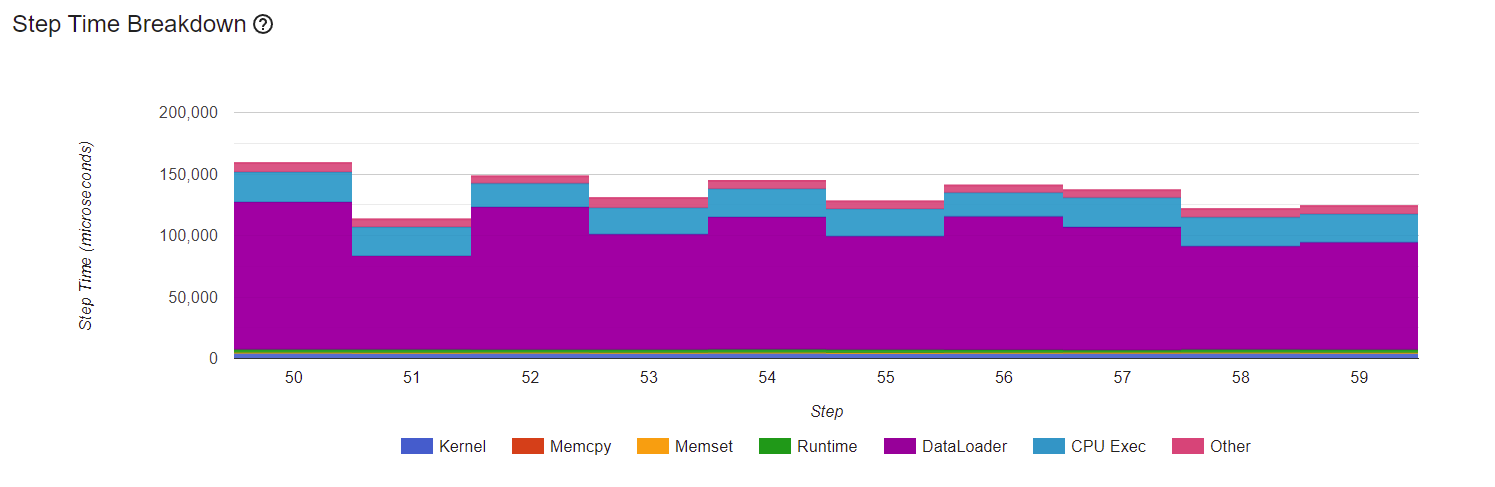

Typically, recording only a few iterations/spans is enough. In very particular cases, you might be interested how the speed develops over time. Then, it is useful to record and inspect multiple spans.

### GPU Summary
The next window that is useful (if training on GPUs) is the GPU Summary. However, in order to understand the GPU summary, it's good to know a little bit about how cores on a GPU are organized. Below, you see the schematic layout of an Nvidia A100 GPU chip ([source](https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf))

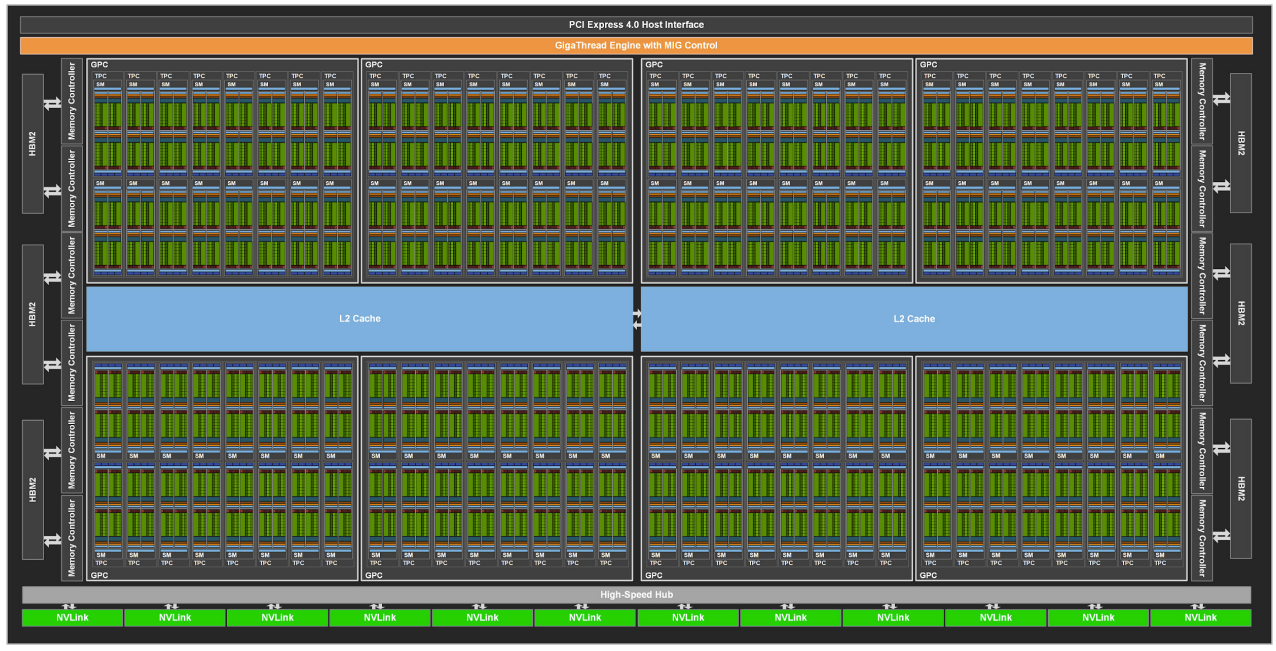

The tiny green dots in this image are GPU cores. They are organized together in groups, so called SM (or: streaming multiprocessor) units. An A100 GPU has 128 SM units. Below, we see a schematic representation of a single SM on an Nvidia A100 GPU

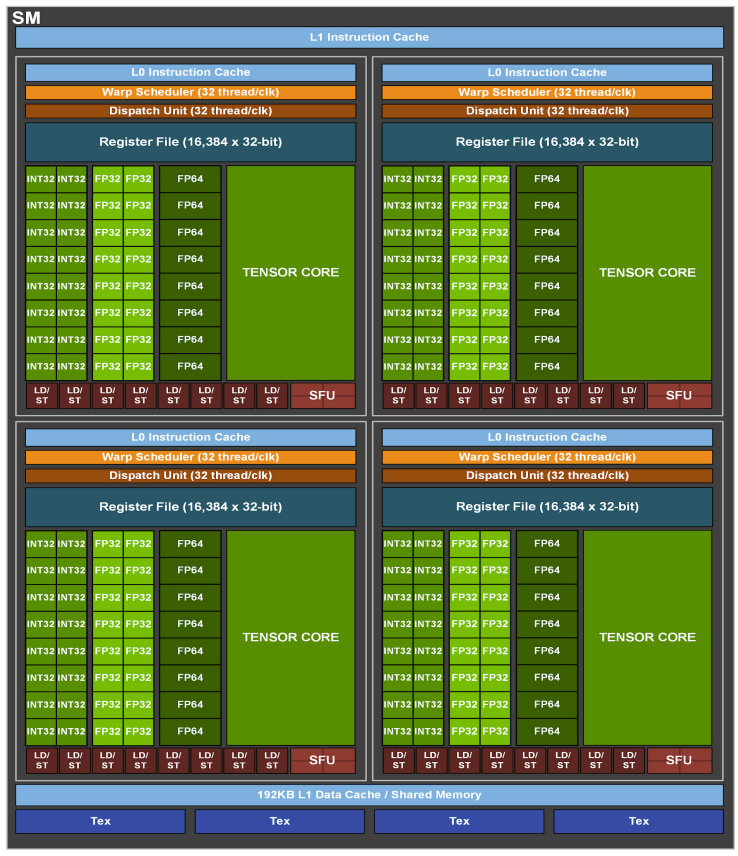

Here, you see that a single SM has many different cores: 16 cores that can perform integer operations, 16 cores that can perform single precision floating point operations (i.e. operations on numbers represented in memory by 32 bits), 8 cores that can perform double precision floating point operations (i.e. operations on numbers represented in memory by 64 bits) and a block of Tensor Cores (special cores for tensor operations). An SM only has a single instruction unit. What that means that all cores in an SM can only perform _one_ operation at the same time. I.e. we can not have 1 FP32 core doing subtraction, and the other multiplication, within the same SM unit. Of course, _different_ SM units can work on different things. I.e. this particular GPU could in theory run 128 _different_ operations, and run each of those operations on e.g. 16 single precision floating point numbers _in parallel_. This massive parallelism is what makes a GPU so good at processing many data elements with the same operation, as is done in a lot of matrix operations.

Ok, back to the summary.

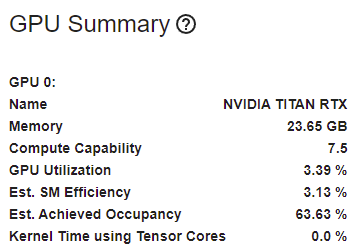

The first thing to note here is the GPU Utilization. As we can see, in this example it is only 3.39%. That means that 96.61% of the time our GPU was doing _nothing_, typically because it is waiting for other resources (I/O, CPU, ...). That's bad: we have a very expensive GPU in this machine, and we're hardly using it!

Note that a high GPU utilization does not _necessarily_ mean we are using the GPU efficiently. Even if just a _single_ core (out of the thousands that a GPU has) is working on a task the full time, GPU utilization would be 100%. However, it would mean we are only using a single core, on a single SM, leaving all of those others idle. As you can see, a high GPU utilization is not a _guarantee_ for efficient usage, but it is a _minimum requirement_.

The Est SM Efficiency provides us some deeper insight. It is the (average) fraction of SMs that were in use over the profiled time period. A low percentage here means SMs have been idling. The aforementioned extreme case of a single core (in a single SM) working all the time would immediately be identified with this metric: GPU utilization would be 100%, but Est SM Efficiency would be 1/128 (in case of an A100 with 128 SM units in total). However, a high Est SM Efficiency is _still_ not enough to guarantee efficient usage. A use case that occupies _one_ core in each SM would also show a high Est SM Efficiency. In a machine learning workload, (partially) empty SMs can occur if there are operations being performed on relatively small matrices. That can be because input sizes are small, or because the batch size is small. I.e. batch size is _one_ of the things you can explore if you see a low Est. SM Efficiency.

Finally, we see Kernel Time using Tensor Cores. We'll get back to those later.

### Execution Summary
The execution summary gives is an overview of which components took the most time (averaged over the steps in this Span).

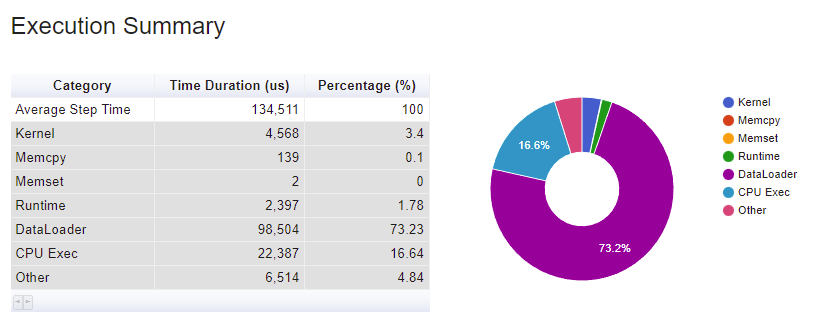

Here, we see that the average step time was 134 ms. The vast majority of that (98ms) was taken by data loading. Another substantial chunk was CPU execution.

### Performance Recommendation

The final part of the overview window is the performance recommendation. Based on the timings measured in the profile, the PyTorch Profiler will try to give you some advice on what to do to speed up your code.

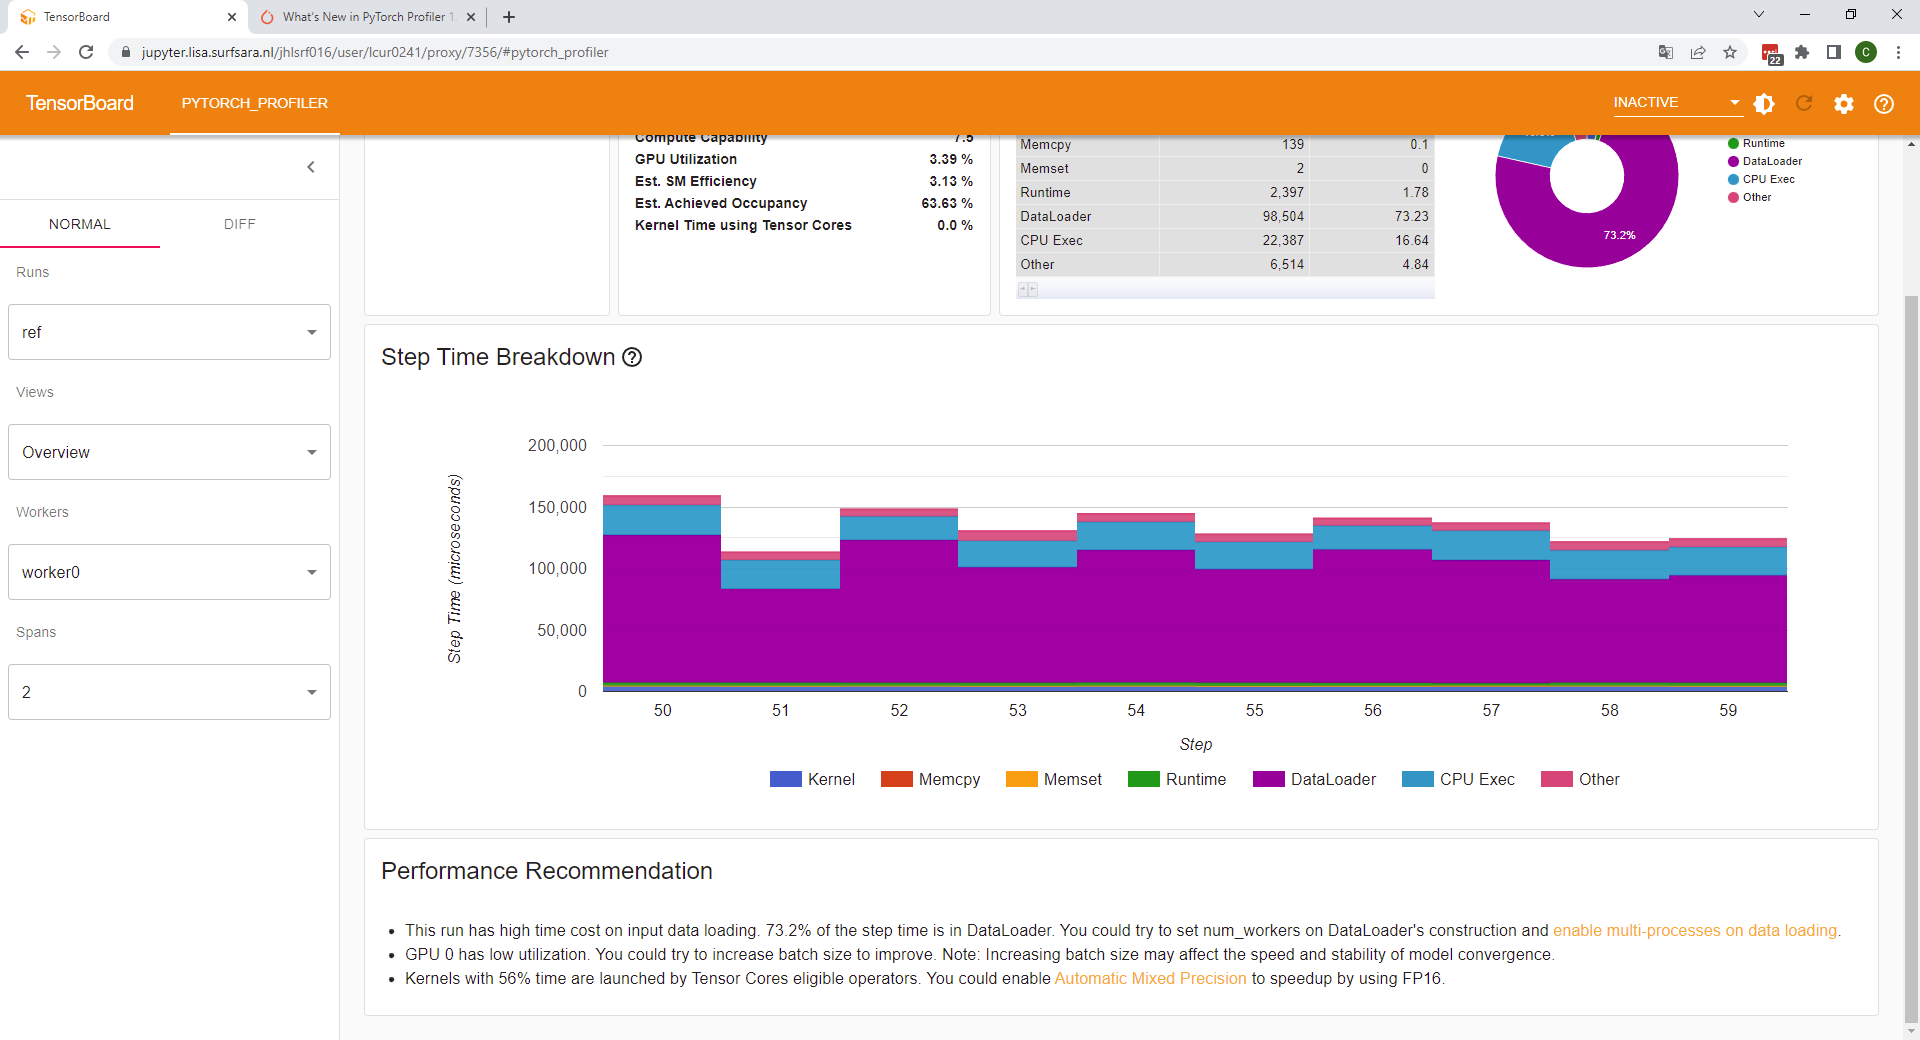

Often, these tips are quite decent, though the Profiler doesn't know what you've already done. Also, which piece of advice will help the most might be better judged by you.

# Improving I/O performance

### Increasing the number of workers for dataloading
We've seen that 73.2% of our time was spent in dataloading, rather than computing anything. Clearly, this is the first problem we want to tackle. Let's start by following the PyTorch profilers advice, and increase the amount of workers (i.e. CPU cores) used for dataloading. 

First, let's see how many cores we have available in this environment:

In [24]:
def get_cpu_count():
    return len(os.sched_getaffinity(0))

print(f"Number of CPUs: {get_cpu_count()}")

Number of CPUs: 2


Since the bulk of our computation happens on the GPU, we can probably use all of the CPU cores we have available for dataloading (if you would be training on the CPUs as well, it might be more efficient to designate a few CPU cores for dataloading, and the rest for training).

Try setting the NUM_DATALOADER_WORKERS to 2,

Files already downloaded and verified
Files already downloaded and verified

Test set: Average loss: 2.3034, Accuracy: 993/10000 (10%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.301560	Accuracy: 0.09
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.212611	Accuracy: 0.20


STAGE:2024-04-17 08:27:59 1928042:1928042 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.080974	Accuracy: 0.26


STAGE:2024-04-17 08:27:59 1928042:1928042 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-17 08:27:59 1928042:1928042 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [7680/50000 (15%)]	Loss: 1.967564	Accuracy: 0.33
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.938078	Accuracy: 0.31


STAGE:2024-04-17 08:28:01 1928042:1928042 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-17 08:28:01 1928042:1928042 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-17 08:28:01 1928042:1928042 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.897660	Accuracy: 0.36

Test set: Average loss: 1.8219, Accuracy: 3739/10000 (37%)



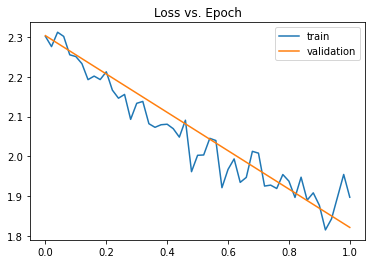

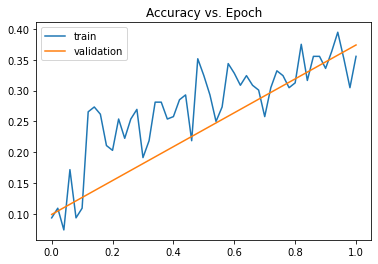

In [25]:
BATCH_SIZE = 256
EPOCHS = 1
LEARNING_RATE = 1e-4
NUM_DATALOADER_WORKERS = 2

LOGGING_INTERVAL = 10  # Controls how often we print the progress bar

model = CIFAR10CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)

transform=transforms.Compose([
    transforms.ToTensor(),
    # Normalize the data to 0 mean and 1 standard deviation, now for all channels of RGB
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


## You can also try this, and see how bad it is:
# train_loader, test_loader = get_dataloaders(
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_DATALOADER_WORKERS,
#     transform=transform
# )

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=train,
        num_workers=NUM_DATALOADER_WORKERS
    )
    for train in (True, False)
)

logdir = "logs/num_dataloaders/" + datetime.now().strftime("%Y%m%d-%H%M%S")

fit_profiling(model, optimizer, EPOCHS, device, train_loader, test_loader, LOGGING_INTERVAL, logdir)

### Inspecting & Interpreting results

You should see something like this:

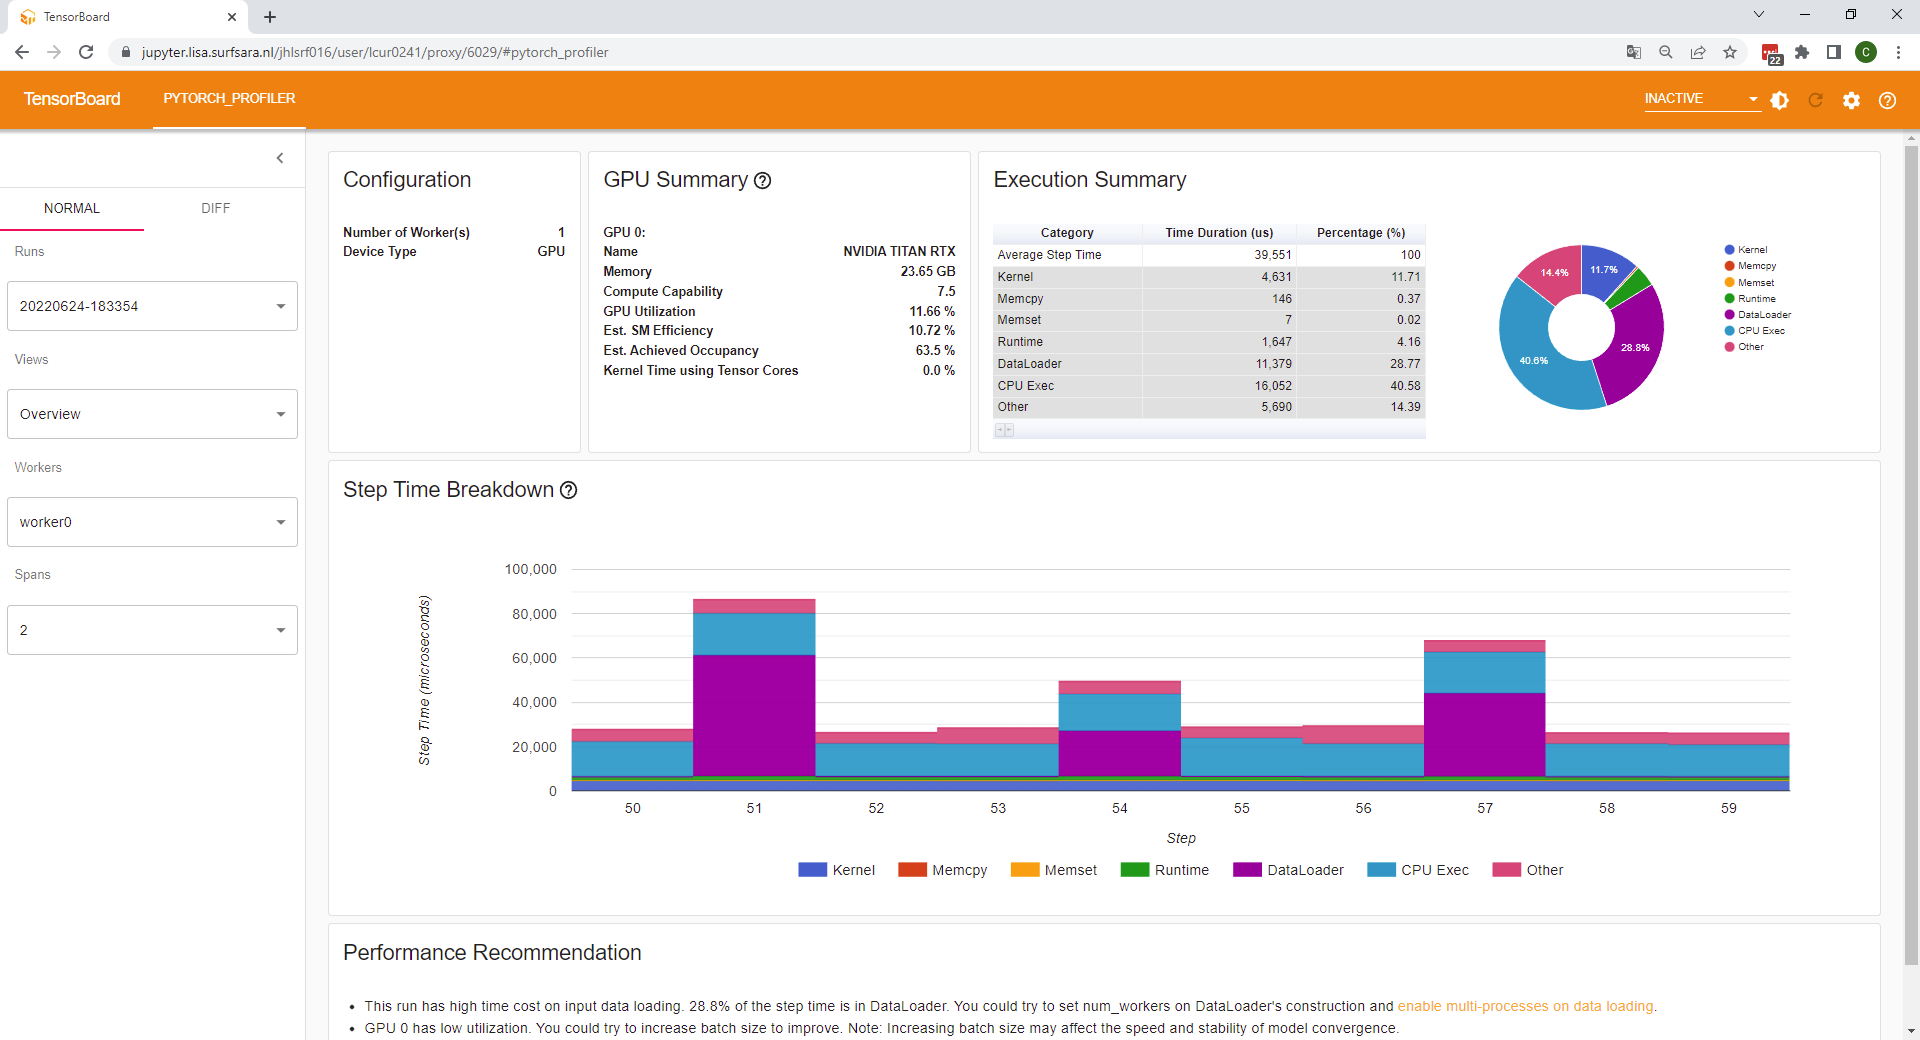

As we can see, the average step time has gone down substantially, to 134 to 39 ms. Note that for codes that are limited by I/O, you might see large variations: we are working on a network filesystem here, meaning that all of us in the course are reading from the same disks. If one of your fellow students is hitting the filesystem at the same time as you are, it might slow down substantially. This variation is also visible between step 51, 54 and 57.

Note that this variation is ***not*** the reason we see so little dataloader time at e.g. step 52 and 53. The data for step 51-53 gets loaded during step 48-50 by the three dataloaders. However, since the computation is faster than the dataloading, the 3 dataloaders are not yet finished when step 51 starts. Thus, step 51 is waiting for the dataloaders to finish before it can start computing, which is what you see as 'DataLoader' time in the profile. Once that I/O is completed, we immediately have ***three*** batches, since we had three dataloaders. That's why step 52 and 53 don't show any Dataloading time anymore.

As we can see, GPU utilization has also gone up to 11% or so. Not great, but still a lot better than before.

### Transformations

Transformations are also part of the Dataloading pipeline. However, these are performed on the CPU and that may take substantially more time that the GPU needs to subsequently train the network. One way to speedup the dataIO is to perform the normalization as part of the network itself, so that it can be executed on the GPU. Note that this is not _always_ useful: it depends on the balance between the amount of work between the GPU and the CPU. If the dataloading on the CPU can already keep up with the GPU, there's no point in offloading more operations to the GPU. In this case, we have a pretty light network however, and we see if we can shave off a little bit more of the dataloading time.

Below, we redefine the network, with the first layer now being the normalization.

In [27]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 4 convolution layers, with a non-linear activation after each.
        # maxpooling after the activations of the 2nd, 3rd, and 4th conv layers
        # 2 dense layers for classification
        # log_softmax
        #
        # As for the number of channels of each layers, try to experiment!

        self.feature_extractor = nn.Sequential(
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # in_features of the first layer should be the product of the output shape of your feature extractor!
        # E.g. if the output of your feature extractor has size (batch x 128 x 4 x 4), in_features = 128*4*4=2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=10),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x):
        features = self.feature_extractor(x)
        
        return self.classifier(features)

Files already downloaded and verified
Files already downloaded and verified

Test set: Average loss: 2.3028, Accuracy: 912/10000 (9%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.303620	Accuracy: 0.08
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.273473	Accuracy: 0.14


STAGE:2024-04-17 08:29:05 1928042:1928042 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-17 08:29:05 1928042:1928042 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-17 08:29:05 1928042:1928042 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.199232	Accuracy: 0.26
Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.119580	Accuracy: 0.27
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.075391	Accuracy: 0.30


STAGE:2024-04-17 08:29:06 1928042:1928042 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-17 08:29:06 1928042:1928042 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-17 08:29:06 1928042:1928042 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.904464	Accuracy: 0.34

Test set: Average loss: 1.9610, Accuracy: 3168/10000 (32%)



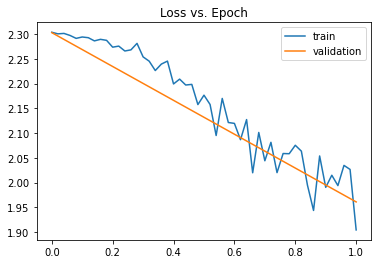

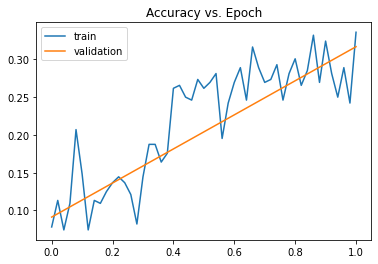

In [28]:
BATCH_SIZE = 256
EPOCHS = 1
LEARNING_RATE = 1e-4
NUM_DATALOADER_WORKERS = 2

LOGGING_INTERVAL = 10  # Controls how often we print the progress bar

model = CIFAR10CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)

transform=transforms.Compose([
    transforms.ToTensor(),
    # Normalization now done in the network
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

## You can also try this, and see how bad it is:
# train_loader, test_loader = get_dataloaders(
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_DATALOADER_WORKERS,
#     transform=transform
# )

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=train,
        num_workers=NUM_DATALOADER_WORKERS
    )
    for train in (True, False)
)

logdir = "logs/transforms/" + datetime.now().strftime("%Y%m%d-%H%M%S")

fit_profiling(model, optimizer, EPOCHS, device, train_loader, test_loader, LOGGING_INTERVAL, logdir)

### Inspecting and interpreting results

You should see something like this

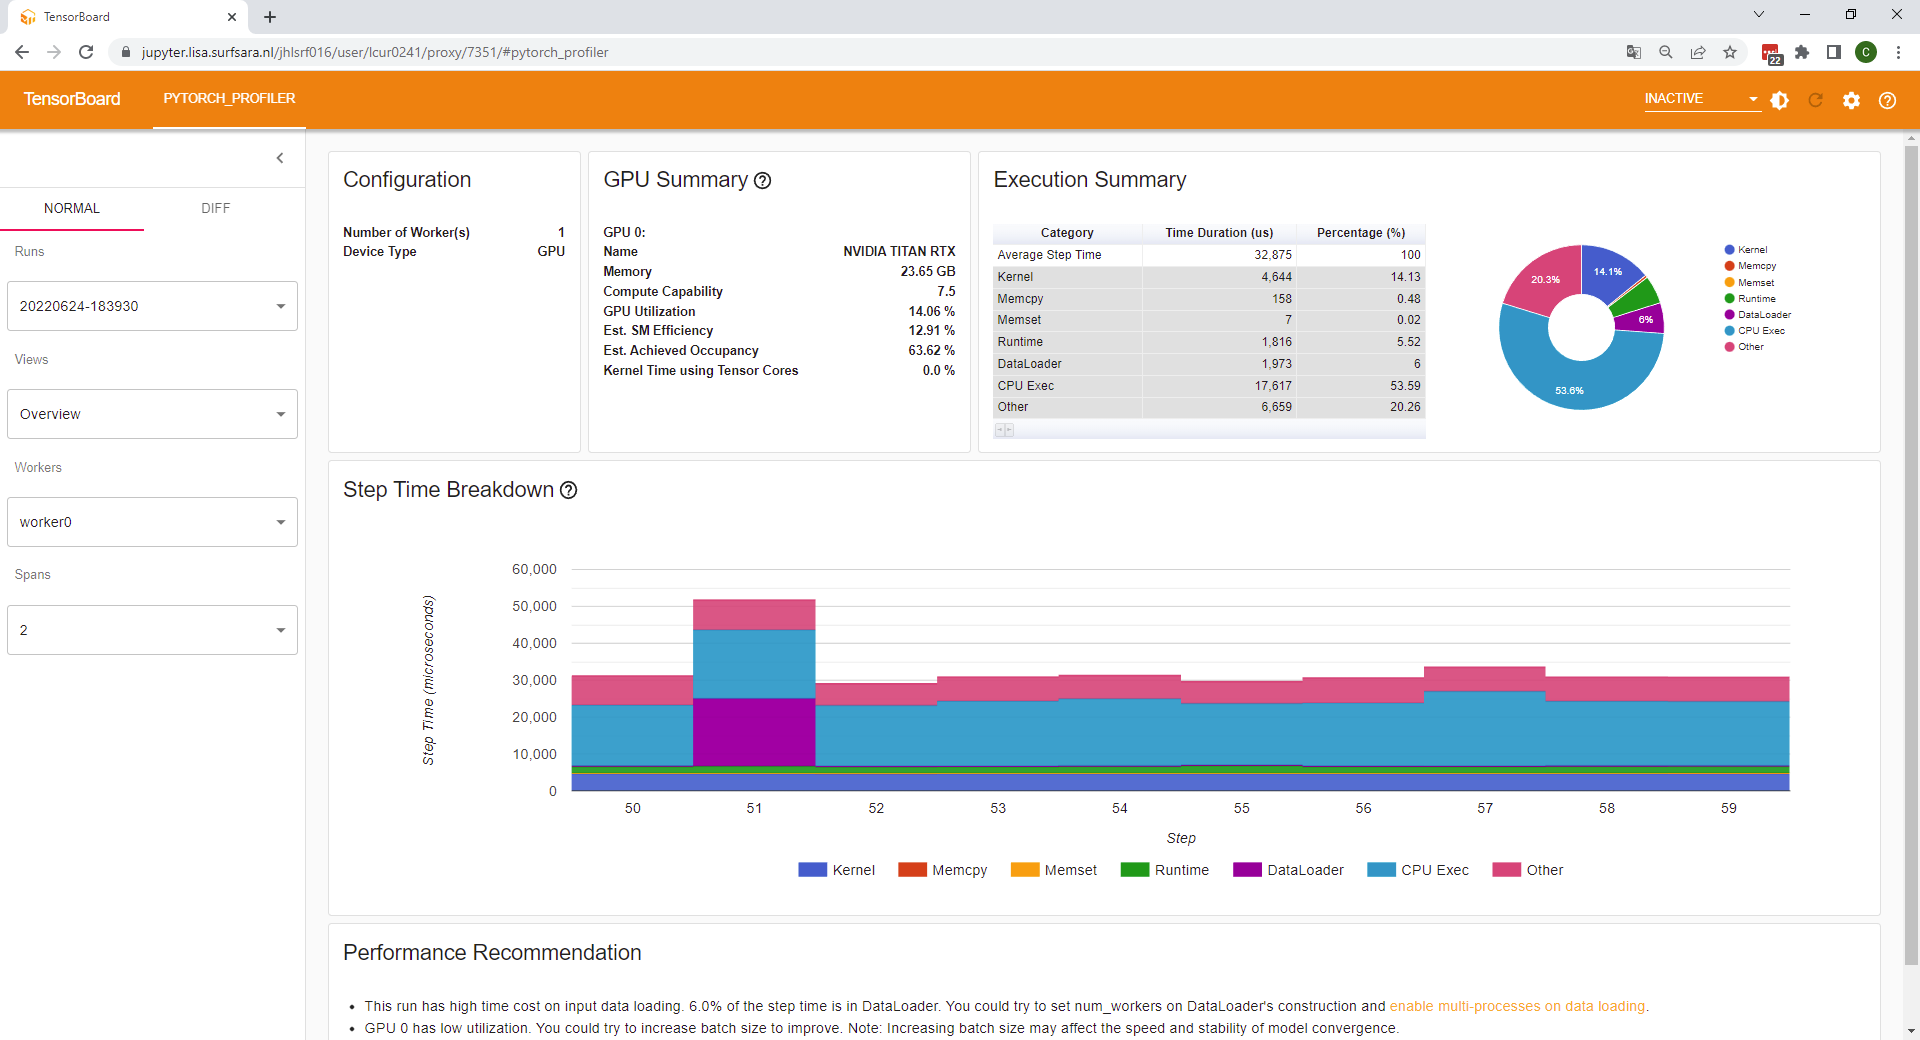

We've managed to reduce step time to 33s now: not a huge gain, but the dataloading part is only 1.9s per step now on average. So, there's not much more to gain. You may see a peak at some steps. If you're eager, you can try to increase the `prefetch_factor`, which is an additional argument you can pass to the `torch.utils.data.DataLoader`. This means more samples will be loaded in advance, and you're less sensitive to fluctuations in I/O speed. However, it will increase (CPU) memory consumption, as you'll need to hold more samples in (CPU) memory. If you feel up to it, you can add it in the code above, rerun the profiling and start a new TensorBoard.

### Final remarks on optimizing I/O

In this case, we've managed to reduce the data loading overhead to almost zero. The reason is that the dataset we work on in this tutorial is tiny: 198 MB in total. This is simply cached by our network filesystem, and therefore I/O is very fast.

In general however, the way this dataset is stored, as one file per sample (image), is ***very bad*** for performance. This is because filesystems need to read metadata (where is the file located, how big is it, updating the last access date, etc) for every individual file. On average, each cifar10 image is about 2KB. Imagine how large the overhead of reading overhead (metadata) for such a small file! This is not a huge issue on e.g. a local laptop with an SSD, since since you're the only one using that disk and since SSDs can do metadata operations very quickly. On large clusters however, metadata operations are (comparatively speaking) very slow. Large clusters typically use network filesystems that are optimized for throughput, i.e. bandwidth, but can process relatively modest amounts of files per second. 

Thus, generally, it is advised to pack samples together in a packed file format. It doesn't hurt on your local laptop, and is all-but-essential on large clusters. Many packed file formats are available, examples are LMDB, HDF5/h5py, TFRecords, petastorm, or even zip or tarballs (but don't compress, since uncompressing takes time too!). One thing to note is that you'll want a packed file format where you can read a _single_ sample without having to load the whole file in memory.

In some clusters, the nodes have local storage. In that case, an option to increase the performance is to first copy the data to local storage. But: also these data copies are a lot faster if you copy a single file, rather than a large amount of small files. So even in those cases, packed file formats are benificial.

## New baseline: a heavier model
Of course, in this tutorial, we've been mostly playing with a toy model. Realistic models are a lot heavier to train. Let's try a real RESNET50 model. Torchvision has such a model defined by default. Let's use it to set a new baseline for our training run.

In [31]:
model = models.resnet50()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Files already downloaded and verified
Files already downloaded and verified

Test set: Average loss: 3.8502, Accuracy: 1000/10000 (10%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.355273	Accuracy: 0.12
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.305168	Accuracy: 0.15


STAGE:2024-04-17 08:32:17 1928042:1928042 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.283683	Accuracy: 0.14


STAGE:2024-04-17 08:32:17 1928042:1928042 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-17 08:32:17 1928042:1928042 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.207158	Accuracy: 0.16
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.236088	Accuracy: 0.19


STAGE:2024-04-17 08:32:23 1928042:1928042 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-17 08:32:24 1928042:1928042 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-17 08:32:24 1928042:1928042 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.131016	Accuracy: 0.21

Test set: Average loss: 2.1614, Accuracy: 1932/10000 (19%)



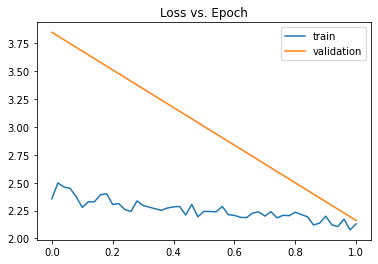

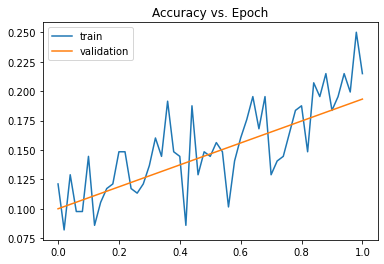

In [33]:
BATCH_SIZE = 256
EPOCHS = 1
LEARNING_RATE = 1e-4
NUM_DATALOADER_WORKERS = 2

LOGGING_INTERVAL = 10  # Controls how often we print the progress bar

# Now use resnet50
model = models.resnet50()
model.conv1 = nn.Sequential(
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=2048),
    nn.ReLU(),
    nn.Linear(in_features=2048, out_features=10),
    nn.LogSoftmax(dim=1)
)
model = model.to(device, memory_format=torch.channels_last)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)

transform=transforms.Compose([
    transforms.ToTensor(),
    # Normalization now done in the network
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

## You can also try this, and see how bad it is:
# train_loader, test_loader = get_dataloaders(
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_DATALOADER_WORKERS,
#     transform=transform
# )

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=train,
        num_workers=NUM_DATALOADER_WORKERS
    )
    for train in (True, False)
)

logdir = "logs/resnet50_baseline/" + datetime.now().strftime("%Y%m%d-%H%M%S")

fit_profiling(model, optimizer, EPOCHS, device, train_loader, test_loader, LOGGING_INTERVAL, logdir)

### Inspecting and interpreting results

Let's have a look at our new baseline:

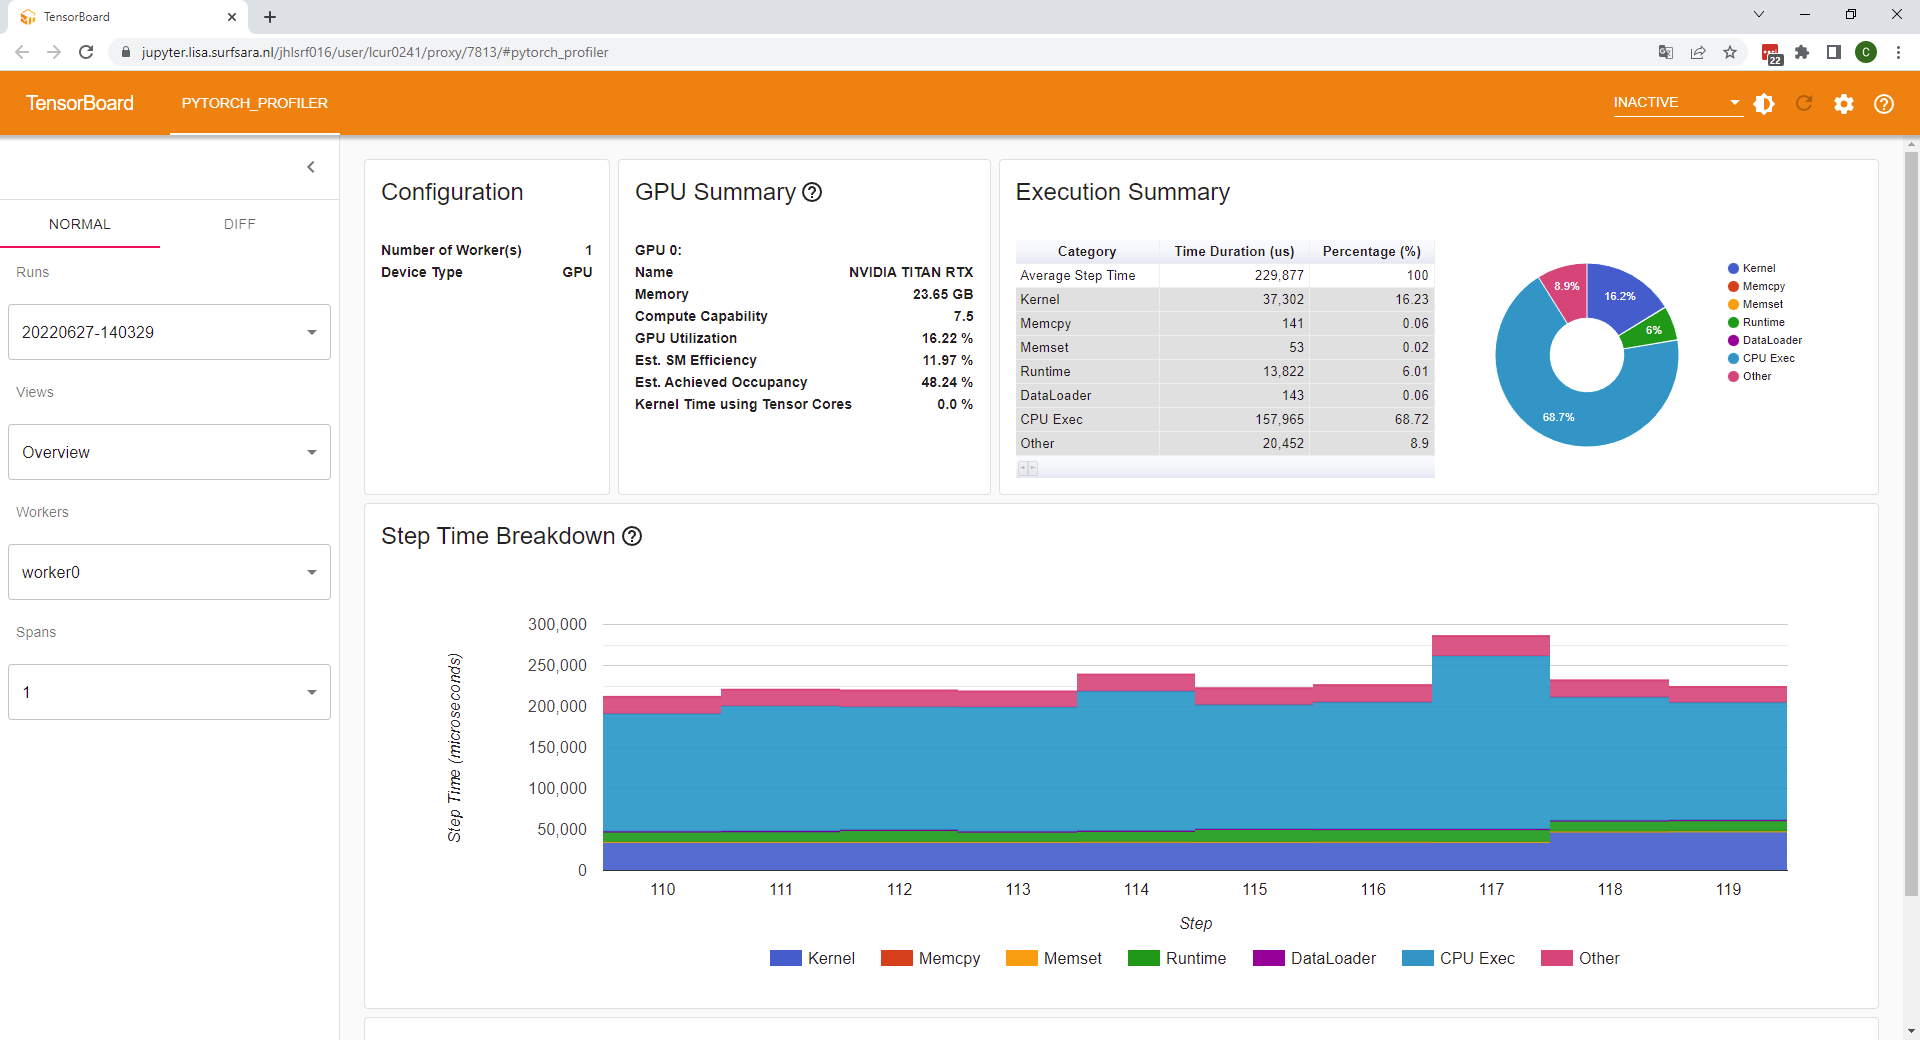

As we can see, a step now takes 229 ms, out of which 37s are spend on GPU kernel execution.

### Improving GPU kernel execution time by mixed precision

Cores on an Nvidia GPU have a dedicated processing unit for processing tensor operations, so-called "Tensor Cores". These can do operations on tensors much faster than when those tensors would have to be performed with the traditional FP32 units in the core.

The operation that these Tensor Cores perform is called a fused-multiply-add, and they do it on a (small) matrix. They can do one of these operations every clock cycle of the GPU:

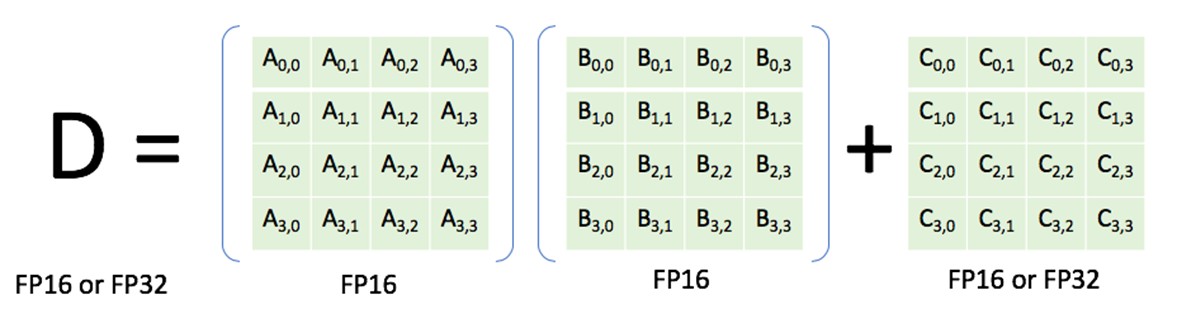

There are some requirements though. On the GPUs that we are working on in this training, the tensor cores only support operations where tensors A and B are stored as 16-bit precision floating point numbers. Tensor C and D can be either 16 or 32 bit. Torch has a specific feature called "automatic mixed precision" (AMP for short), which is supported through the `torch.cuda.amp` package (see [this documentation](https://pytorch.org/docs/stable/amp.html)). In principle, this can be used to automatically convert the right tensors in the model to 16-bit floating point, so that the Tensor Cores can be used. Note however that you may need to 'scale' your gradients: FP16 floating point numbers have a smaller representable range (since they have fewer bits to represent the number), which may cause underflows in your gradients (i.e. numbers in your gradient may become smaller than the smallest number that can be represented with the FP16 datatype). If that happens, you need to do gradient scaling using the `torch.cuda.amp.GradScaler`. In the below example, we exlcuded that, since here we just want to demonstrate the potential speedup.

Files already downloaded and verified

Test set: Average loss: 4.8199, Accuracy: 1000/10000 (10%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.343052	Accuracy: 0.10
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.359744	Accuracy: 0.11
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.297154	Accuracy: 0.11
Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.361629	Accuracy: 0.11
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.334318	Accuracy: 0.09
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.348753	Accuracy: 0.10

Test set: Average loss: 2.3351, Accuracy: 1033/10000 (10%)



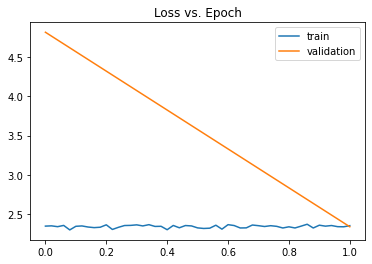

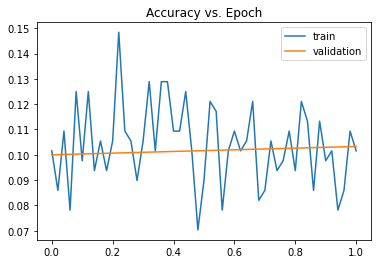

In [32]:
BATCH_SIZE = 256
EPOCHS = 1
LEARNING_RATE = 1e-4
NUM_DATALOADER_WORKERS = 2

LOGGING_INTERVAL = 10  # Controls how often we print the progress bar

# Now use resnet50
model = models.resnet50()
model.conv1 = nn.Sequential(
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=2048),
    nn.ReLU(),
    nn.Linear(in_features=2048, out_features=10),
    nn.LogSoftmax(dim=1)
)
model = model.to(device, memory_format=torch.channels_last)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)

transform=transforms.Compose([
    transforms.ToTensor(),
    # Normalization now done in the network
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

## You can also try this, and see how bad it is:
# train_loader, test_loader = get_dataloaders(
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_DATALOADER_WORKERS,
#     transform=transform
# )

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=train,
        num_workers=NUM_DATALOADER_WORKERS
    )
    for train in (True, False)
)


logdir = "logs/autocast/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Here, we use automatic mixed precision:

from torch import autocast

with autocast(device_type='cuda'):
    fit_profiling(model, optimizer, EPOCHS, device, train_loader, test_loader, LOGGING_INTERVAL, logdir)

### Inspecting and interpreting results

You should see something like this

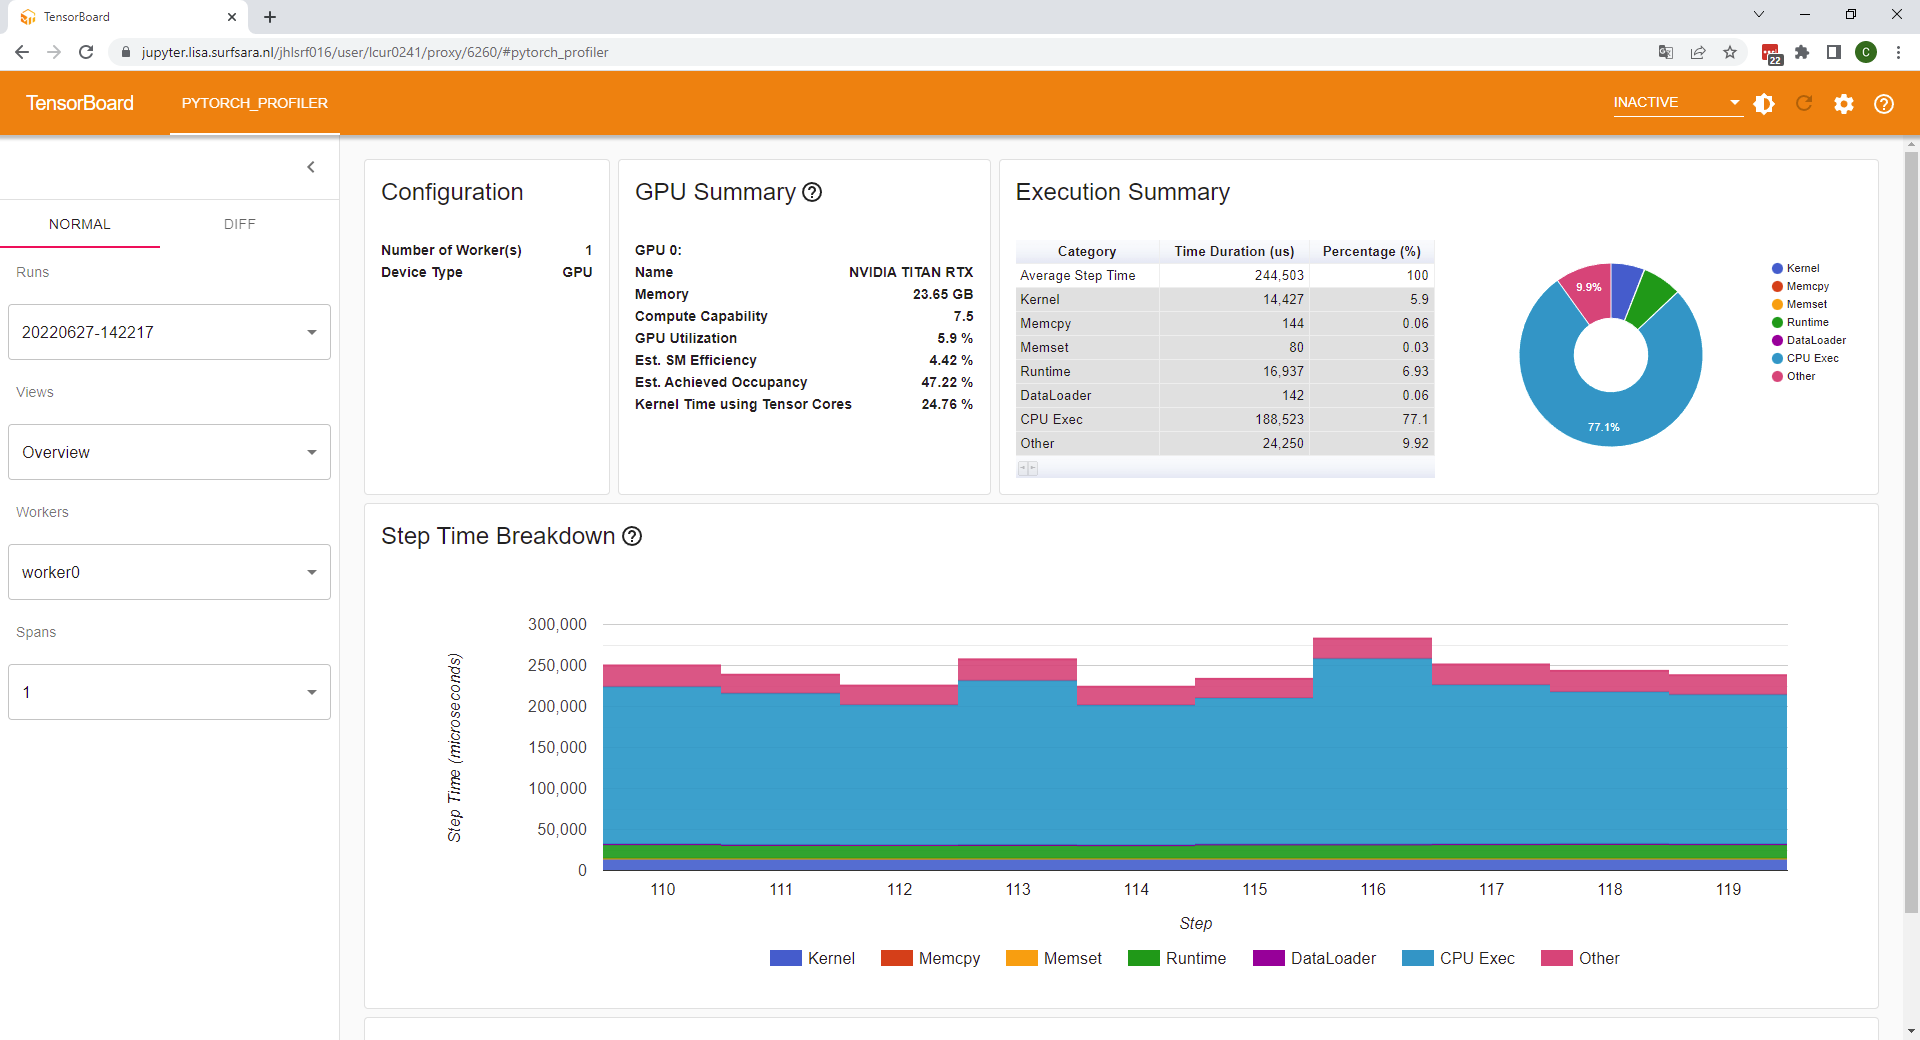

We'll focus on the GPU kernel execution time here. It has decreased from about 37 to 14 ms, and the GPU summary now tells us that almost 25% of the time spent on executing kernels, it is using the Tensor Cores. You might have noticed that GPU utilization has gone _down_ in this case, compared to our baseline run. However, here, that's not a bad thing: we have essentially reduced the _amount of work_ that needed to be done by moving to reduced precision. 

What _is_ problematic though is that the CPU Exec time has gone up. While we haven't confirmed this, we think it is due to the extra overhead introduced by the type conversion from FP32 to FP16. So, for this particular network and (small) input, it is not worth it to use mixed precision - but in many real world cases it does provide a substantial speedup!

## Other views of the profiler
Here, we'll just discuss some of the other views of the profiler, without exercises.

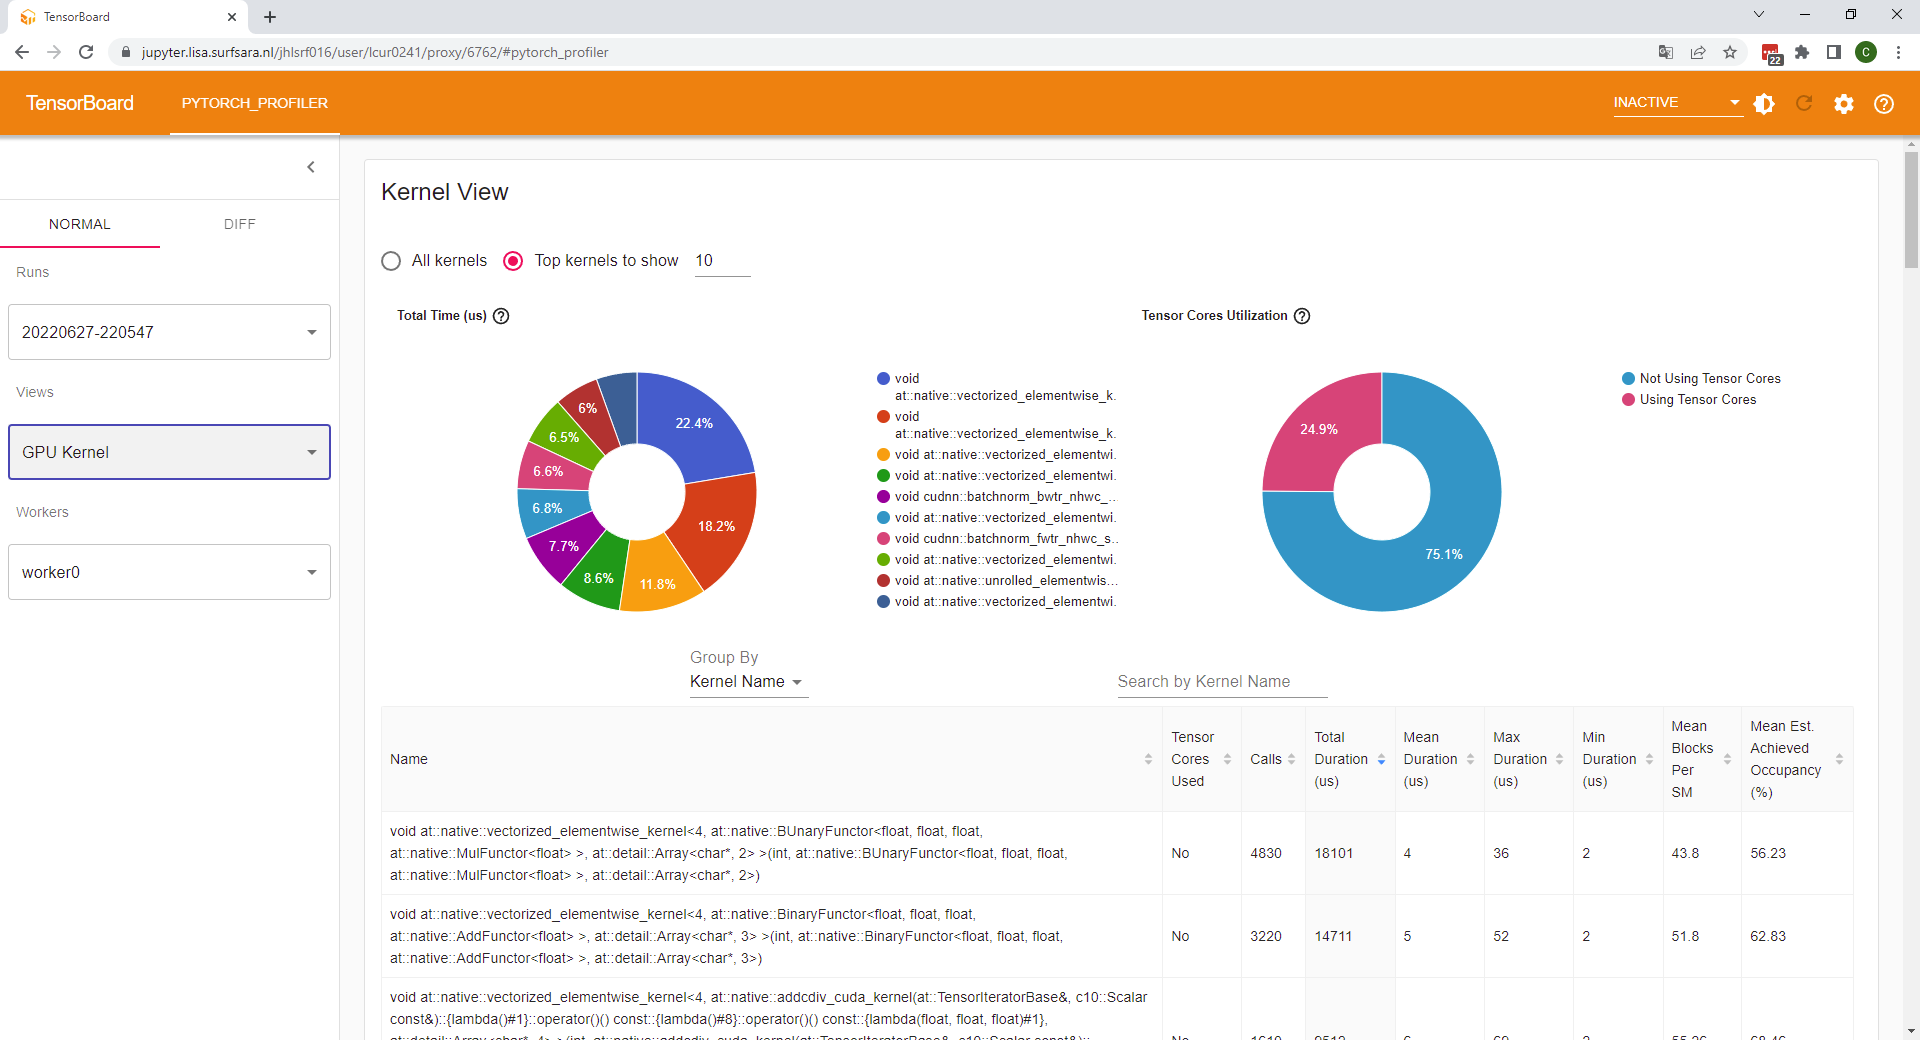

In the GPU kernel view, you see a list of all GPU kernels that have been executed. You can see a lot of details, like how often these particular kernels have been run, how much time that took, if the kernel ran on tensor cores or not, and things like mean estimated achieved occupancy (we have talked about this metric before when discussing the GPU summary). It's hard to gain actionable information from this view.

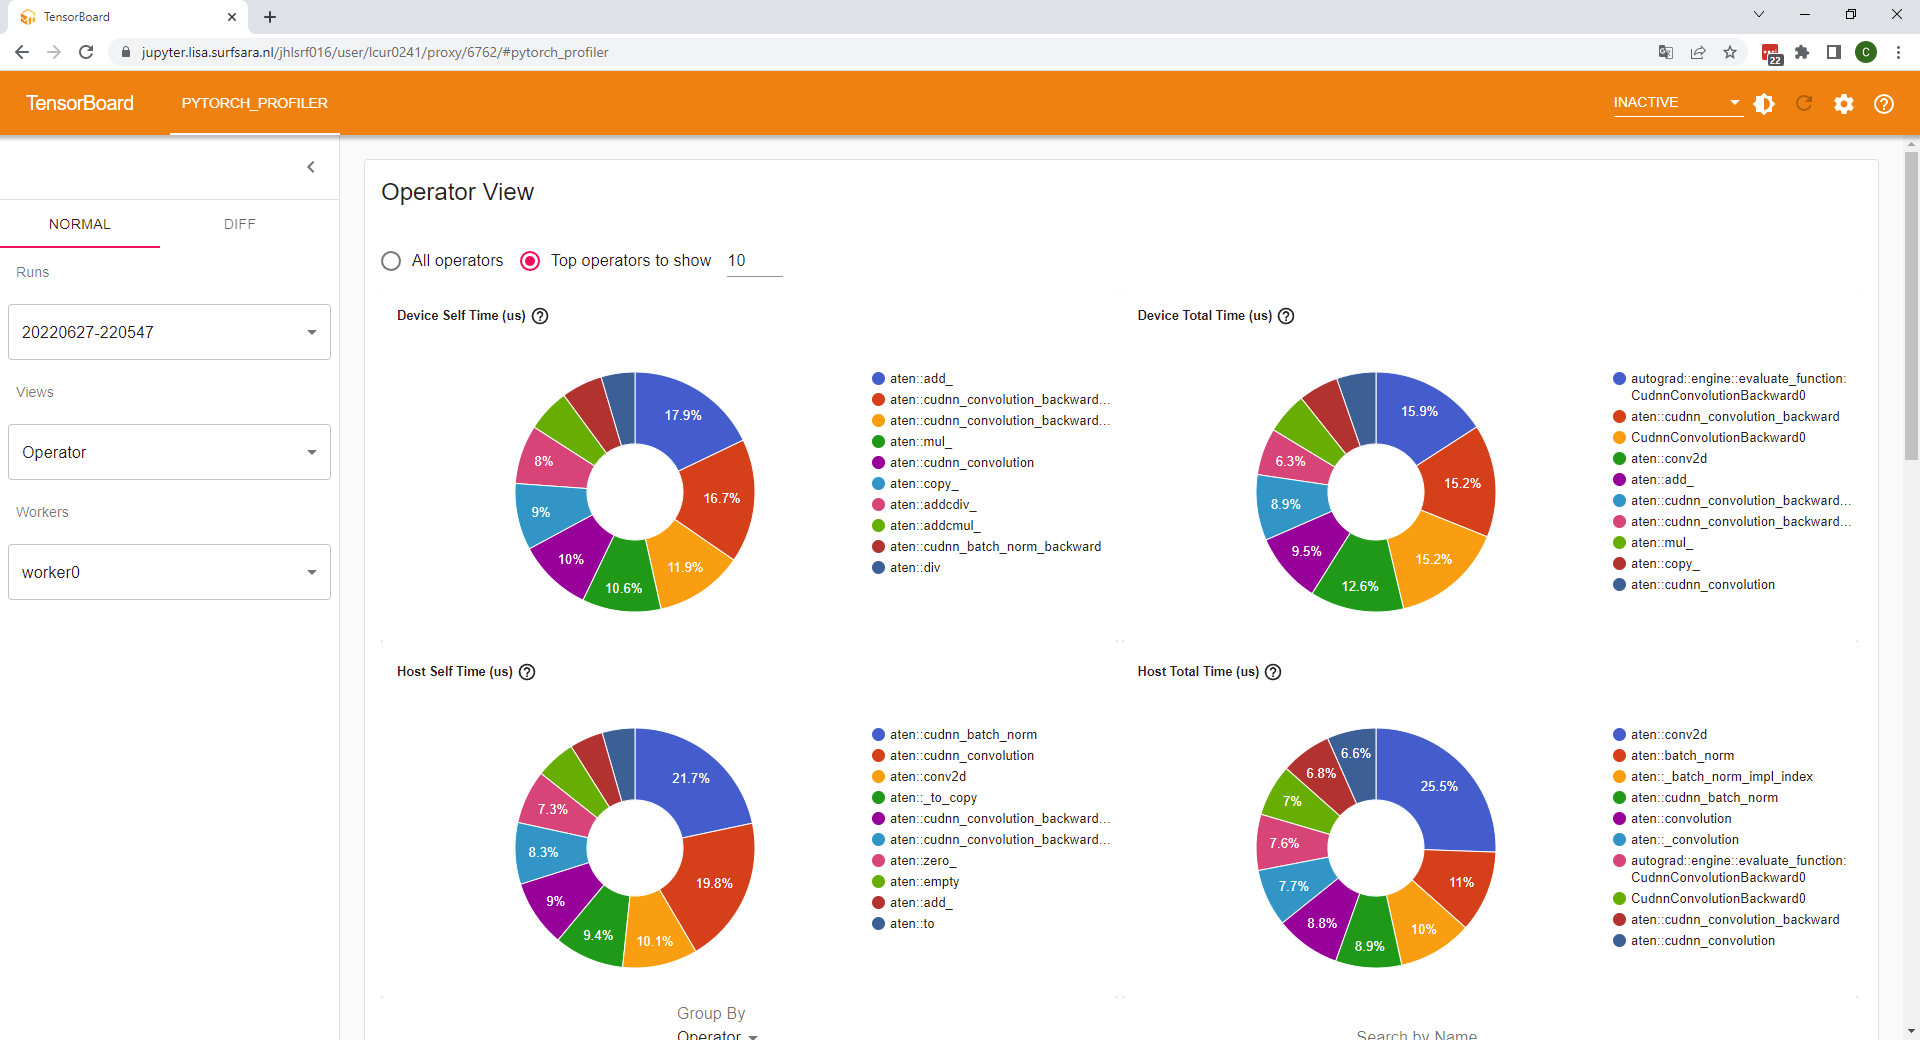
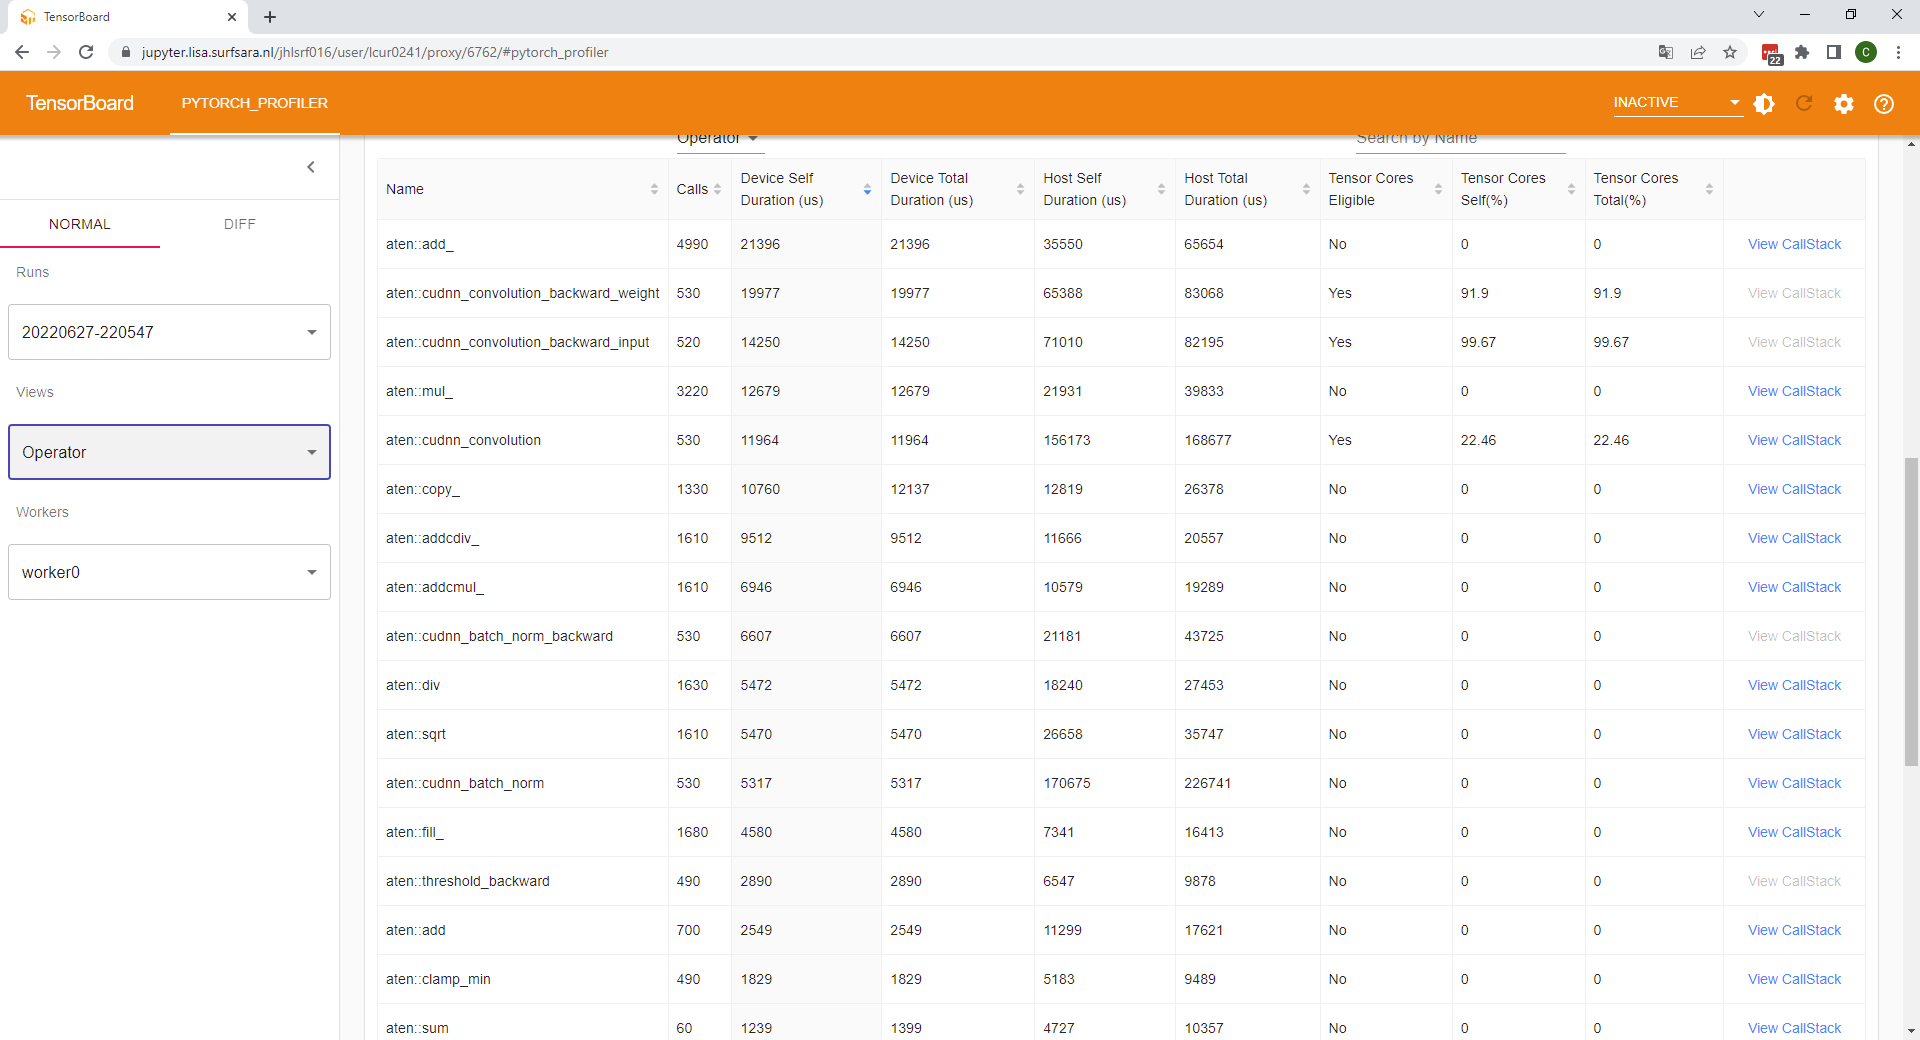

The operator view shows all PyTorch operations that have been executed. The question marks next to the pie graphs give some additional explaination about what you see there. Similarly, though it gives some interesting insights into which operators take the most time in your computation, its hard to gain actionable insight from this.

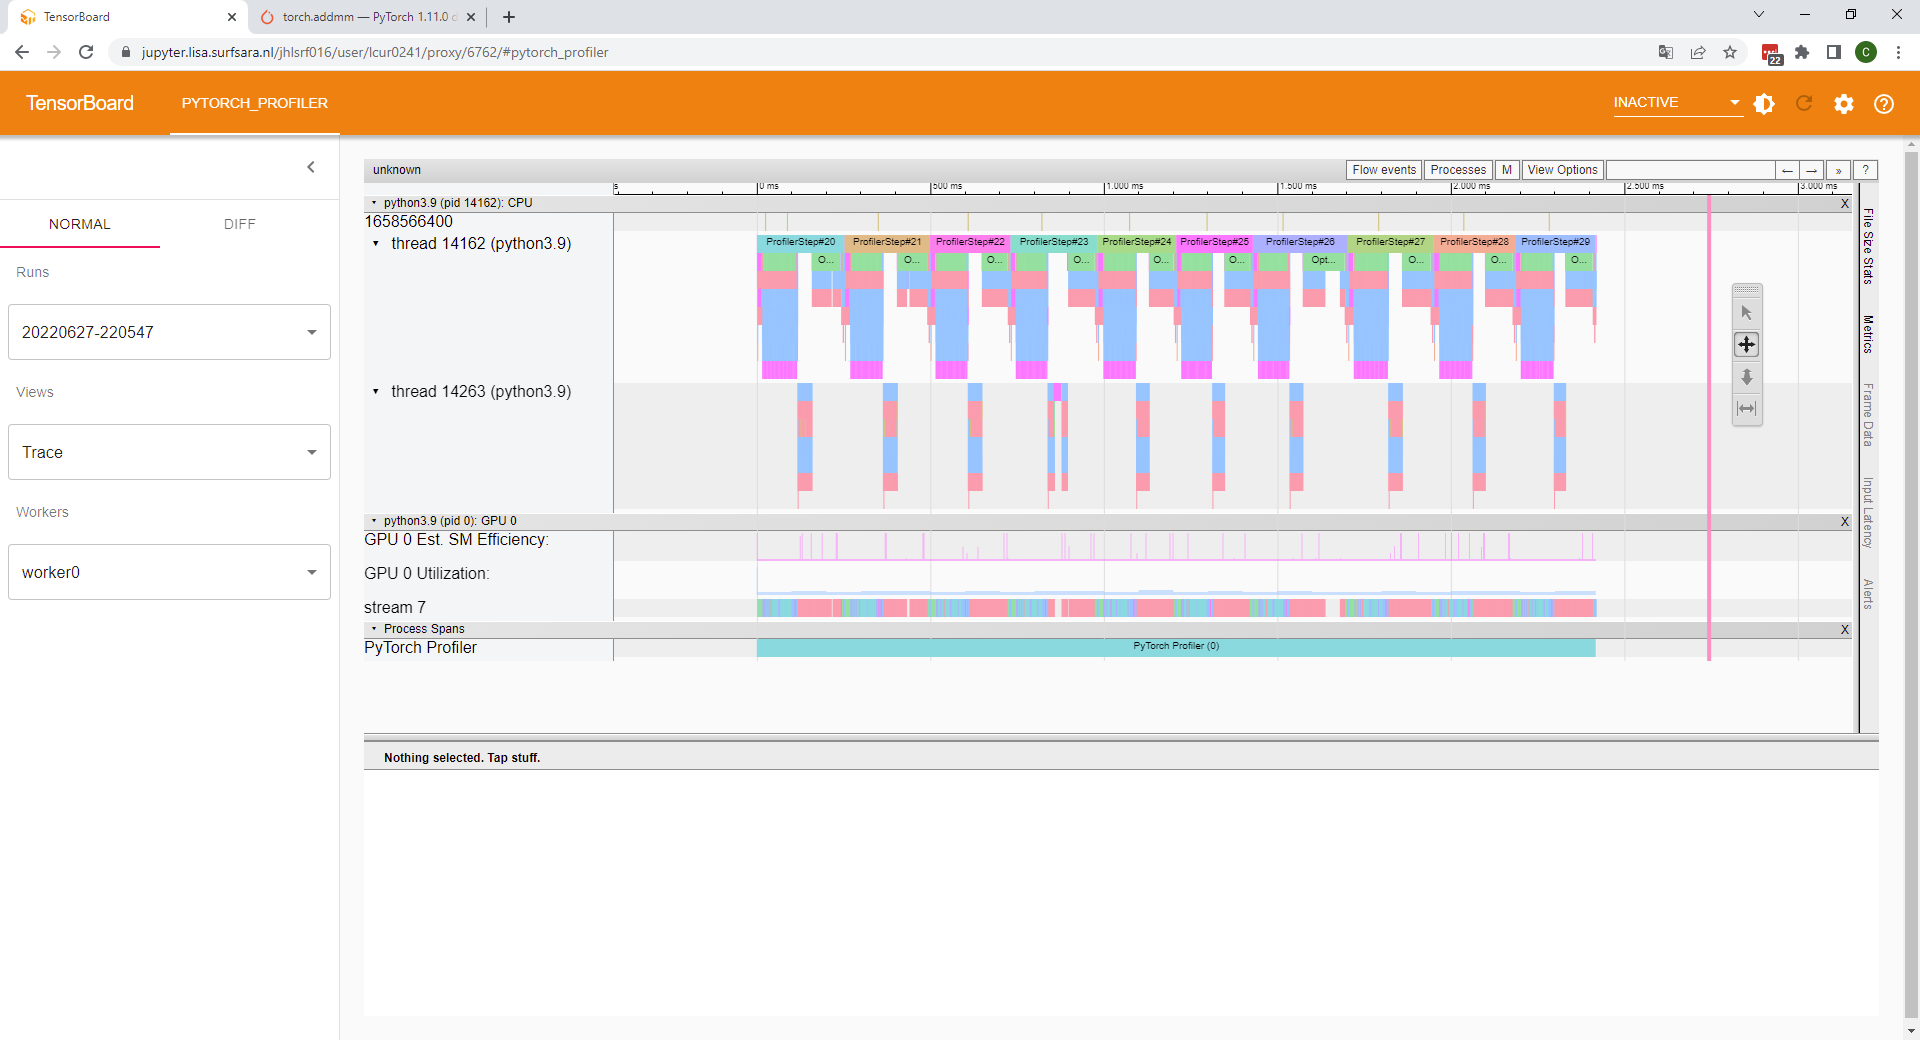

In the trace view, we see a timeline of the execution of the training iterations. At the top, we clearly recognize the 10 iterations that we profiled. Let's zoom in on one step:

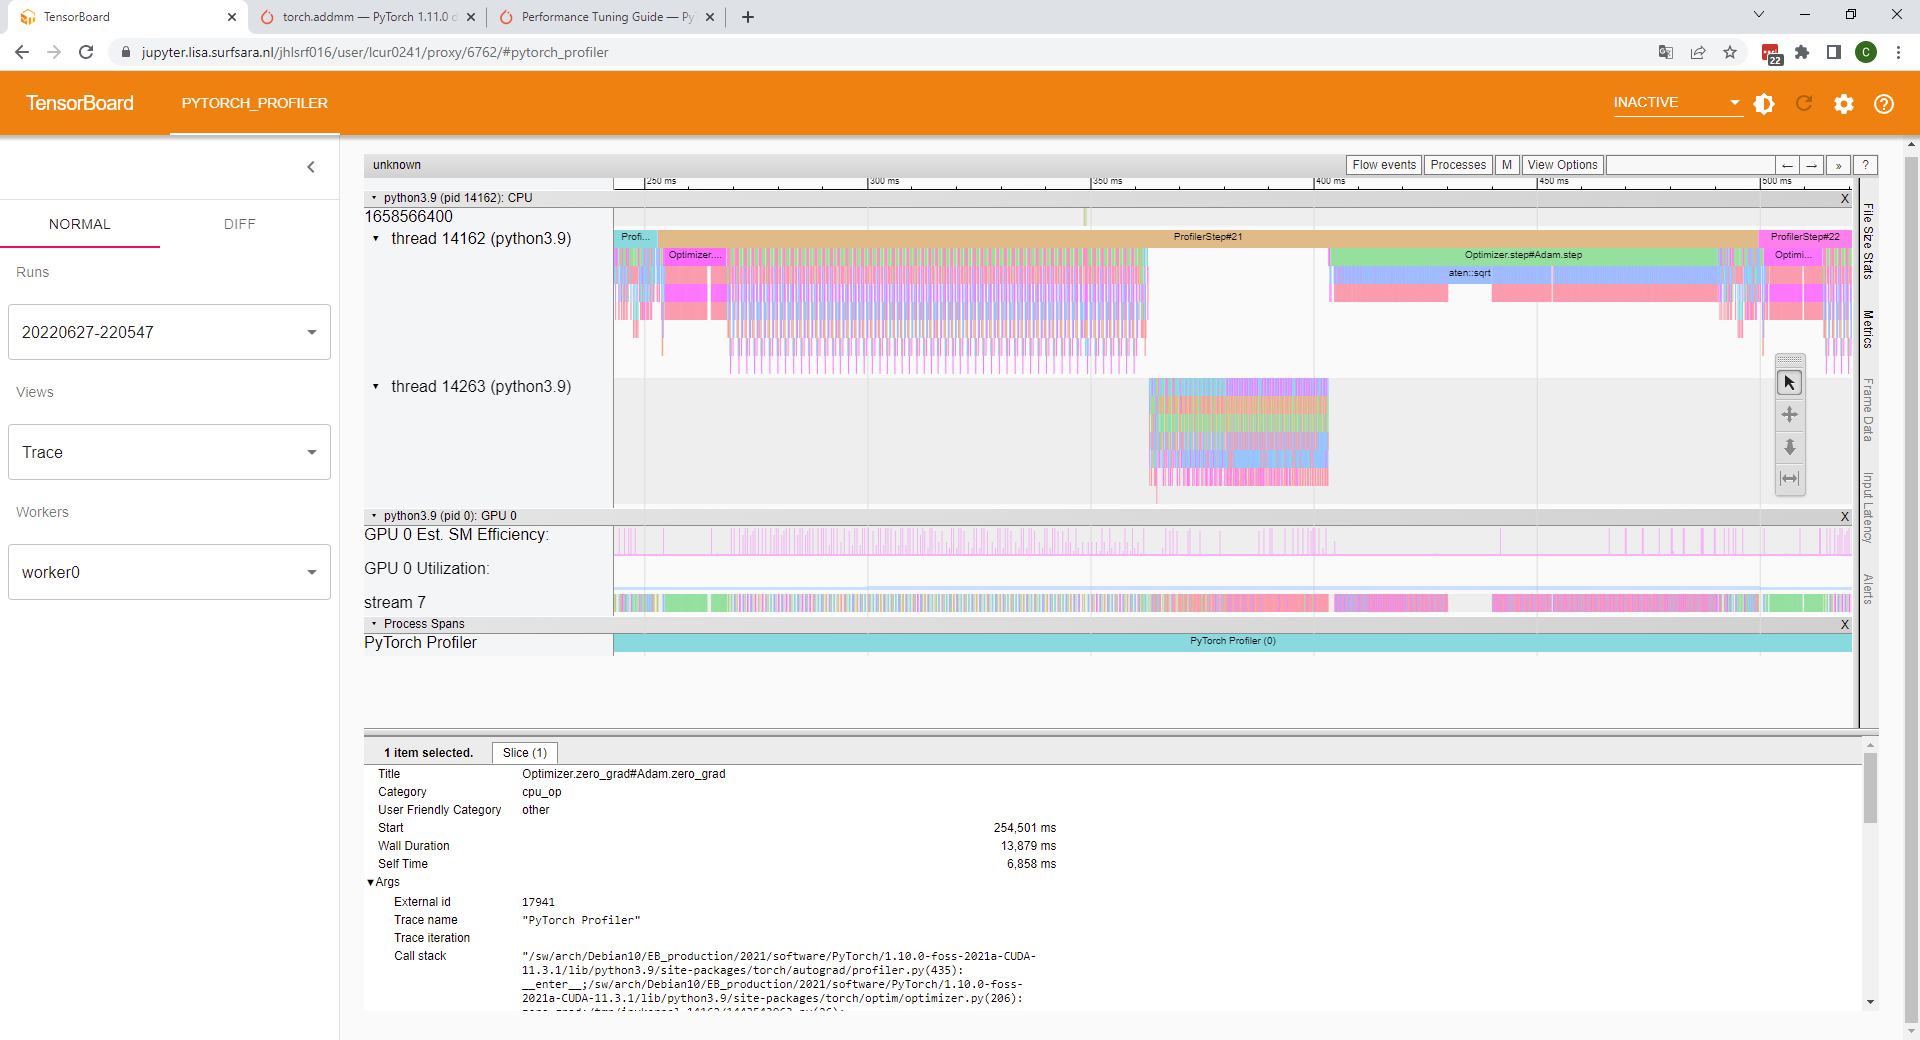

The two 'threads' at the top show the processes that execute on the CPU. The 'stream 7' shows the kernels that execute on the GPU. You can click on certain operations to see what they are, and how long they took. For example, the purple block at the top left that says 'Optimizer...' is now selected. It shows that the full title is 'Optmizer.zero_grad', i.e. this is the process that fills the gradients with zeroes. Let's zoom in on that:

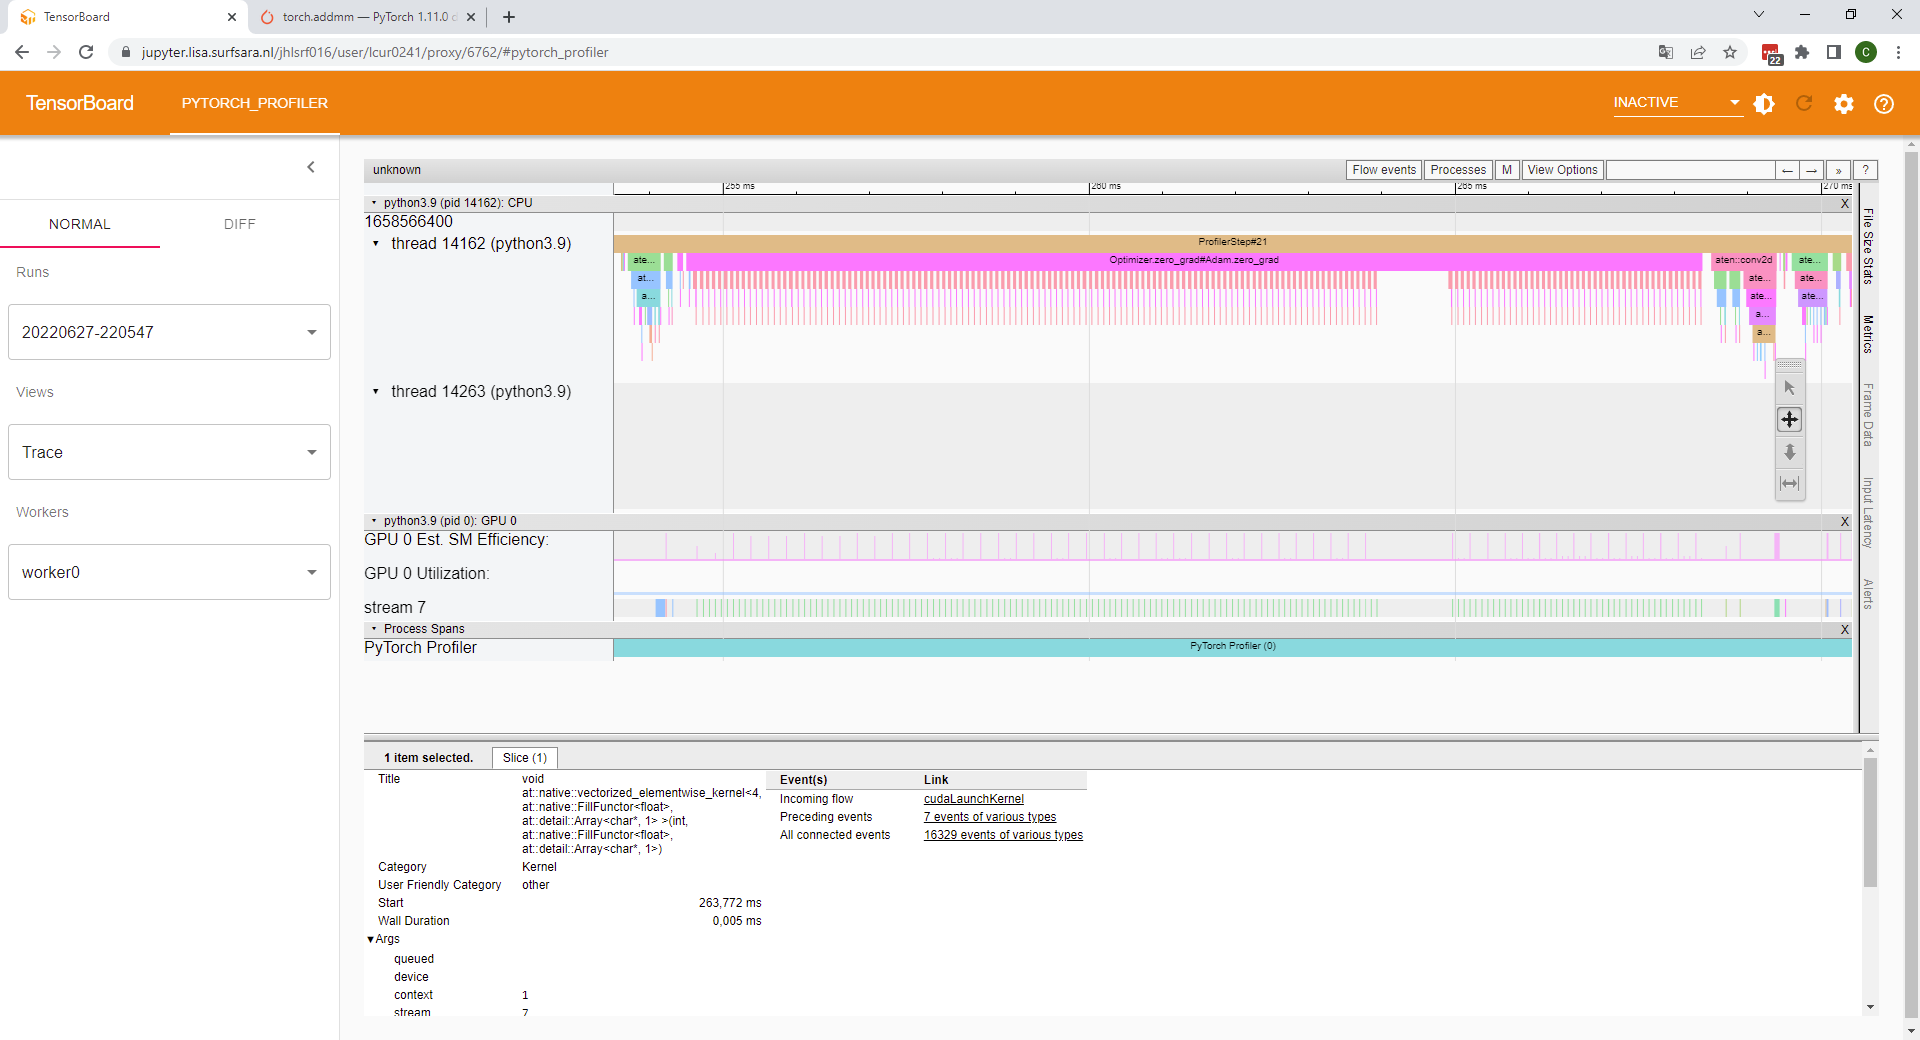

We see some pattern being repeated. Zooming in further, we see:

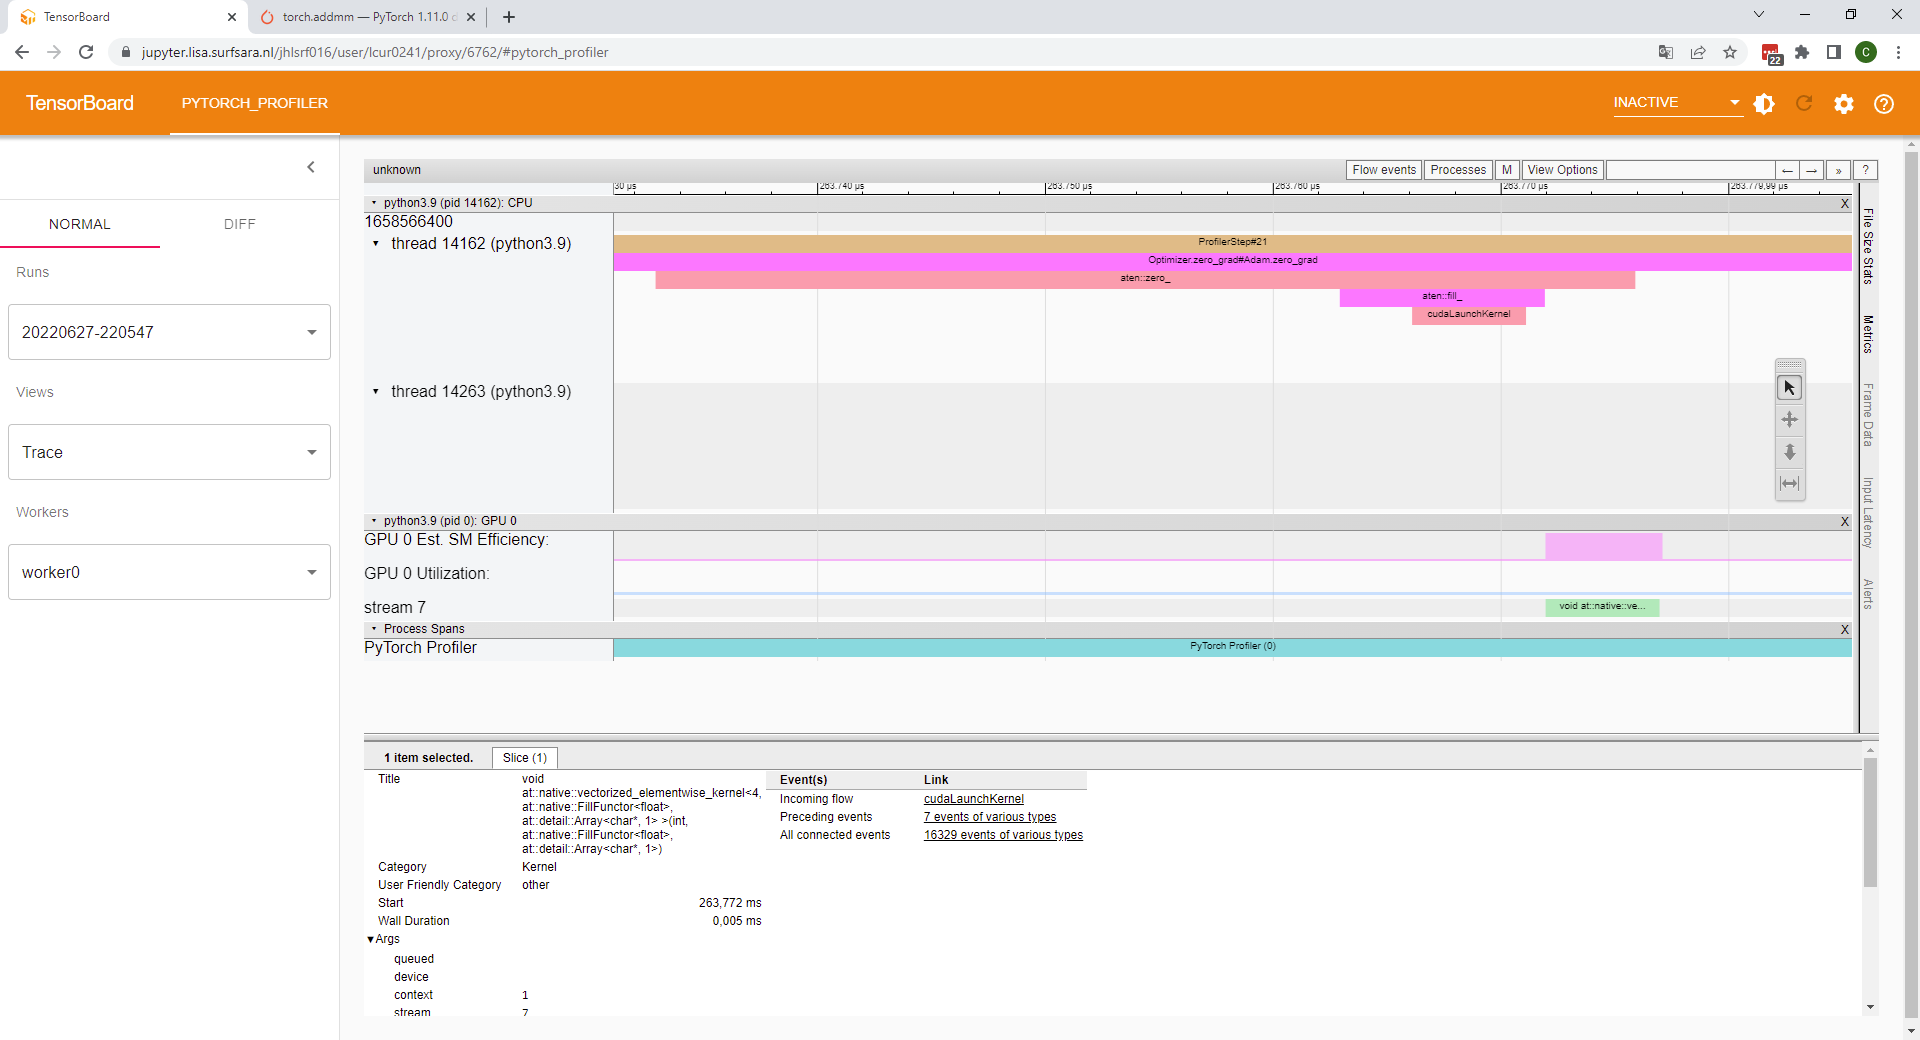

Essentially, you see a call stack here. `Optmizer.zero_grad` called `aten::zero_`, which called `aten::fill_`, which called `cudaLaunchKernel`, which in turn launced a cuda kernel (the green block in stream 7).

While this process doesn't take a _ton_ of time, it is mentioned in the PyTorch tuning guide as one of the things that could be optimized: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html . It is mentioned that one can set the parameters to 'None' instead of to zero explicitely, which may be more efficient, but might incur slightly different numerical behaviour.

Zooming in on another part of the step, we see e.g. the 2D convolutions from the forward pass:

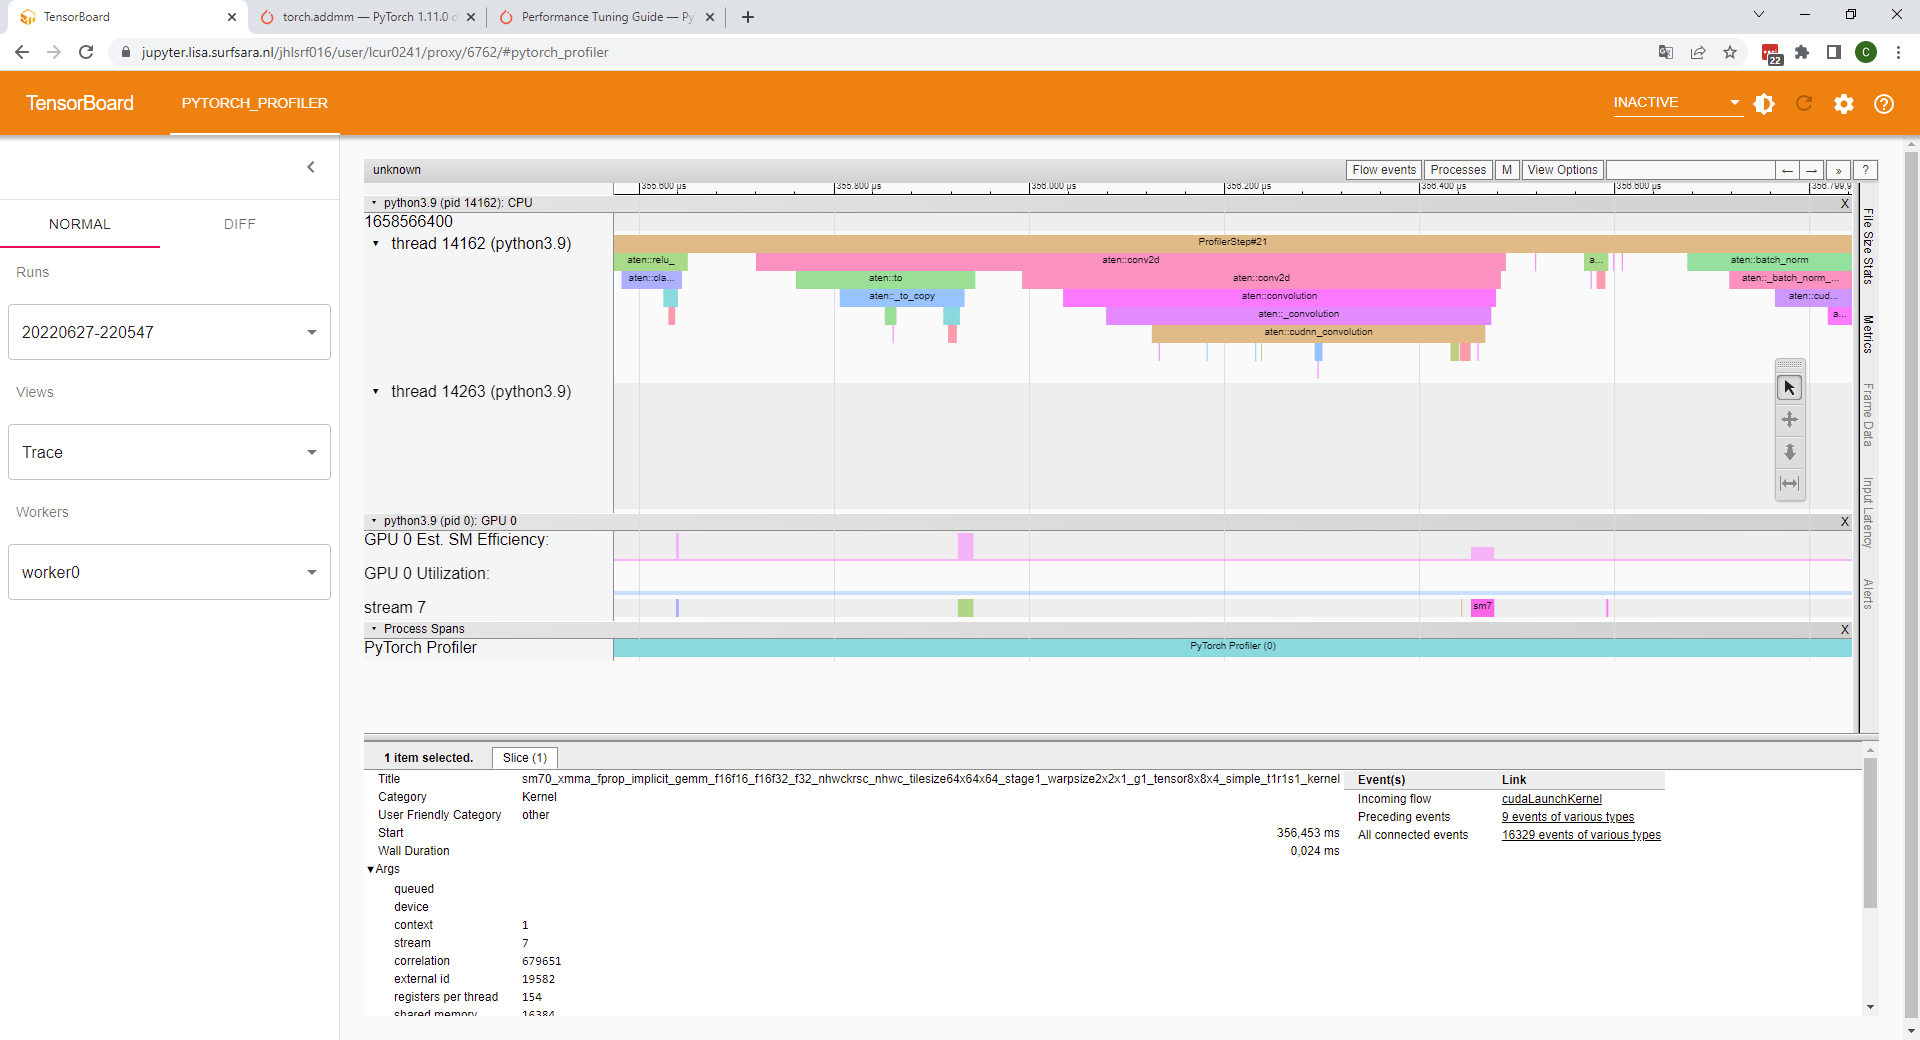

Like before, you can recognize the CPU call stack for the aten::conv2d operation, which eventually results in the laucnh of a kernel on the GPU.

Zooming in on another part, we see some typical part of the backward pass:

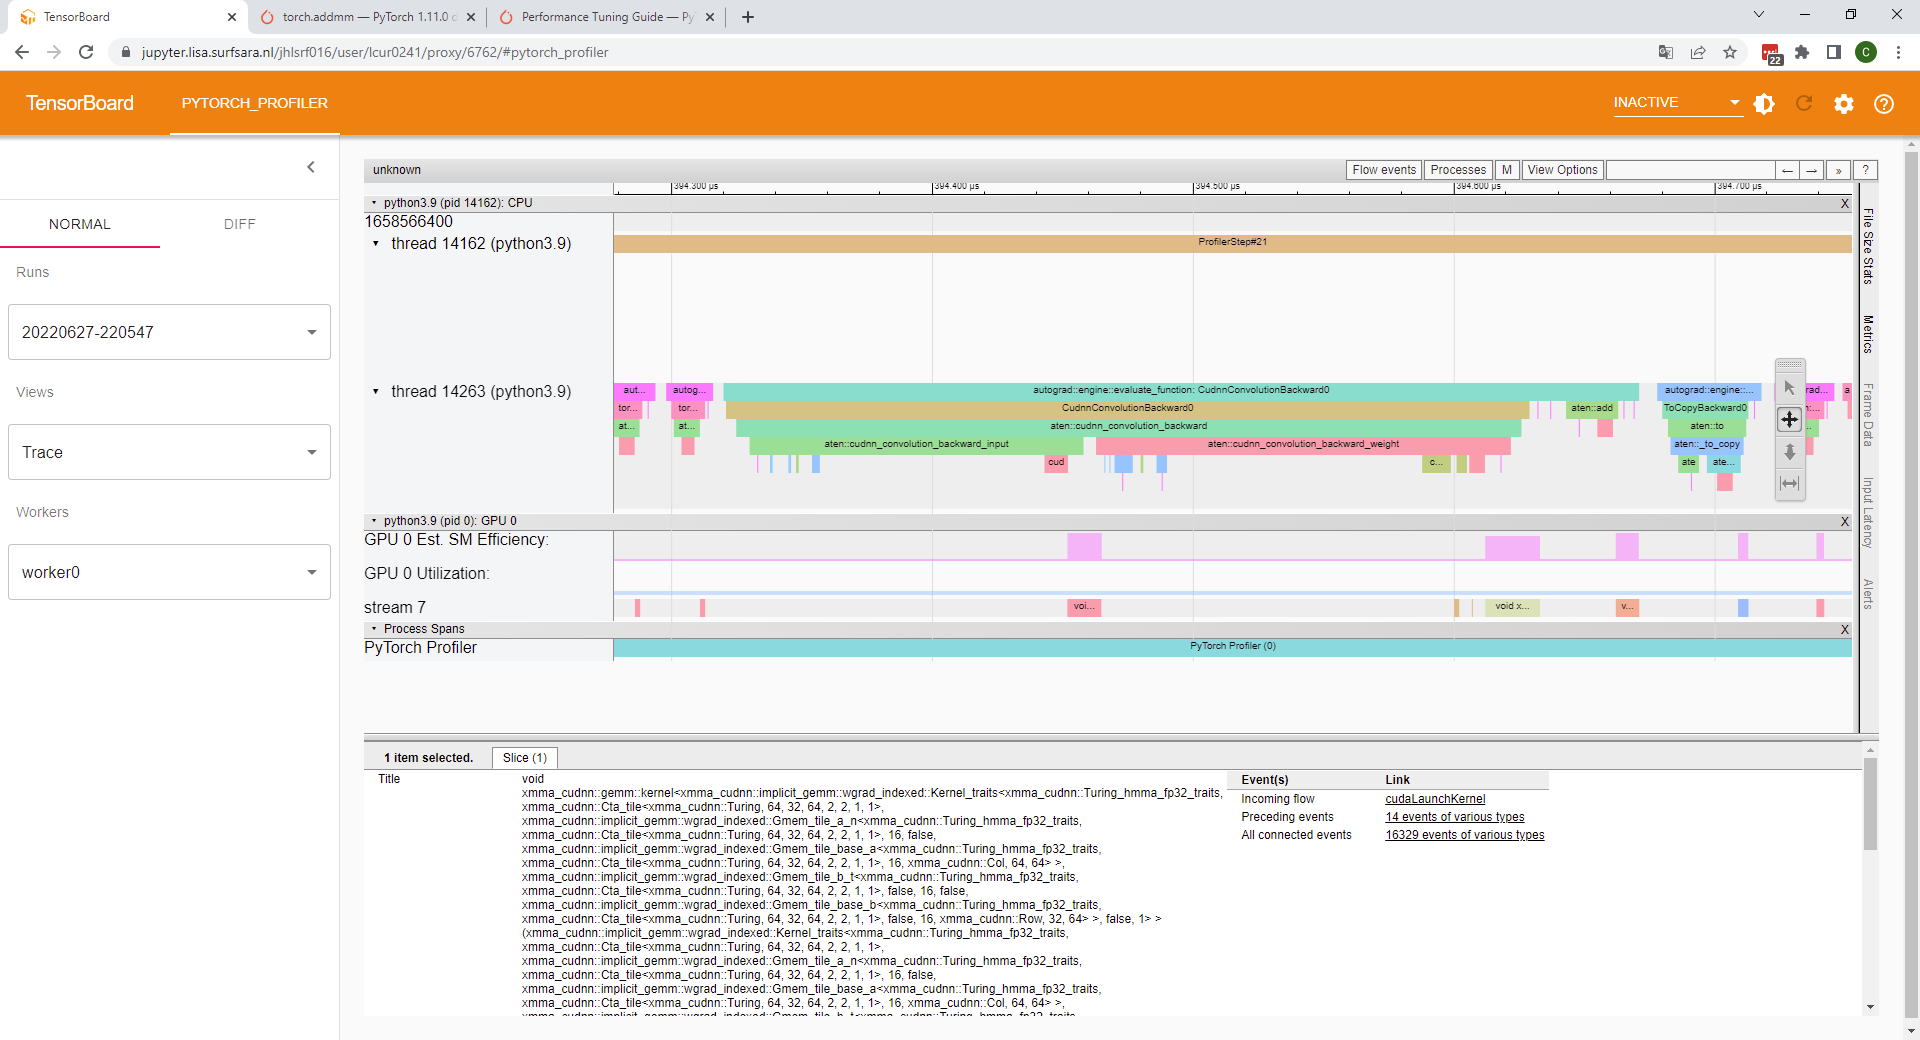

Finally, there's the optimizer step, which will do things like updating the weights:

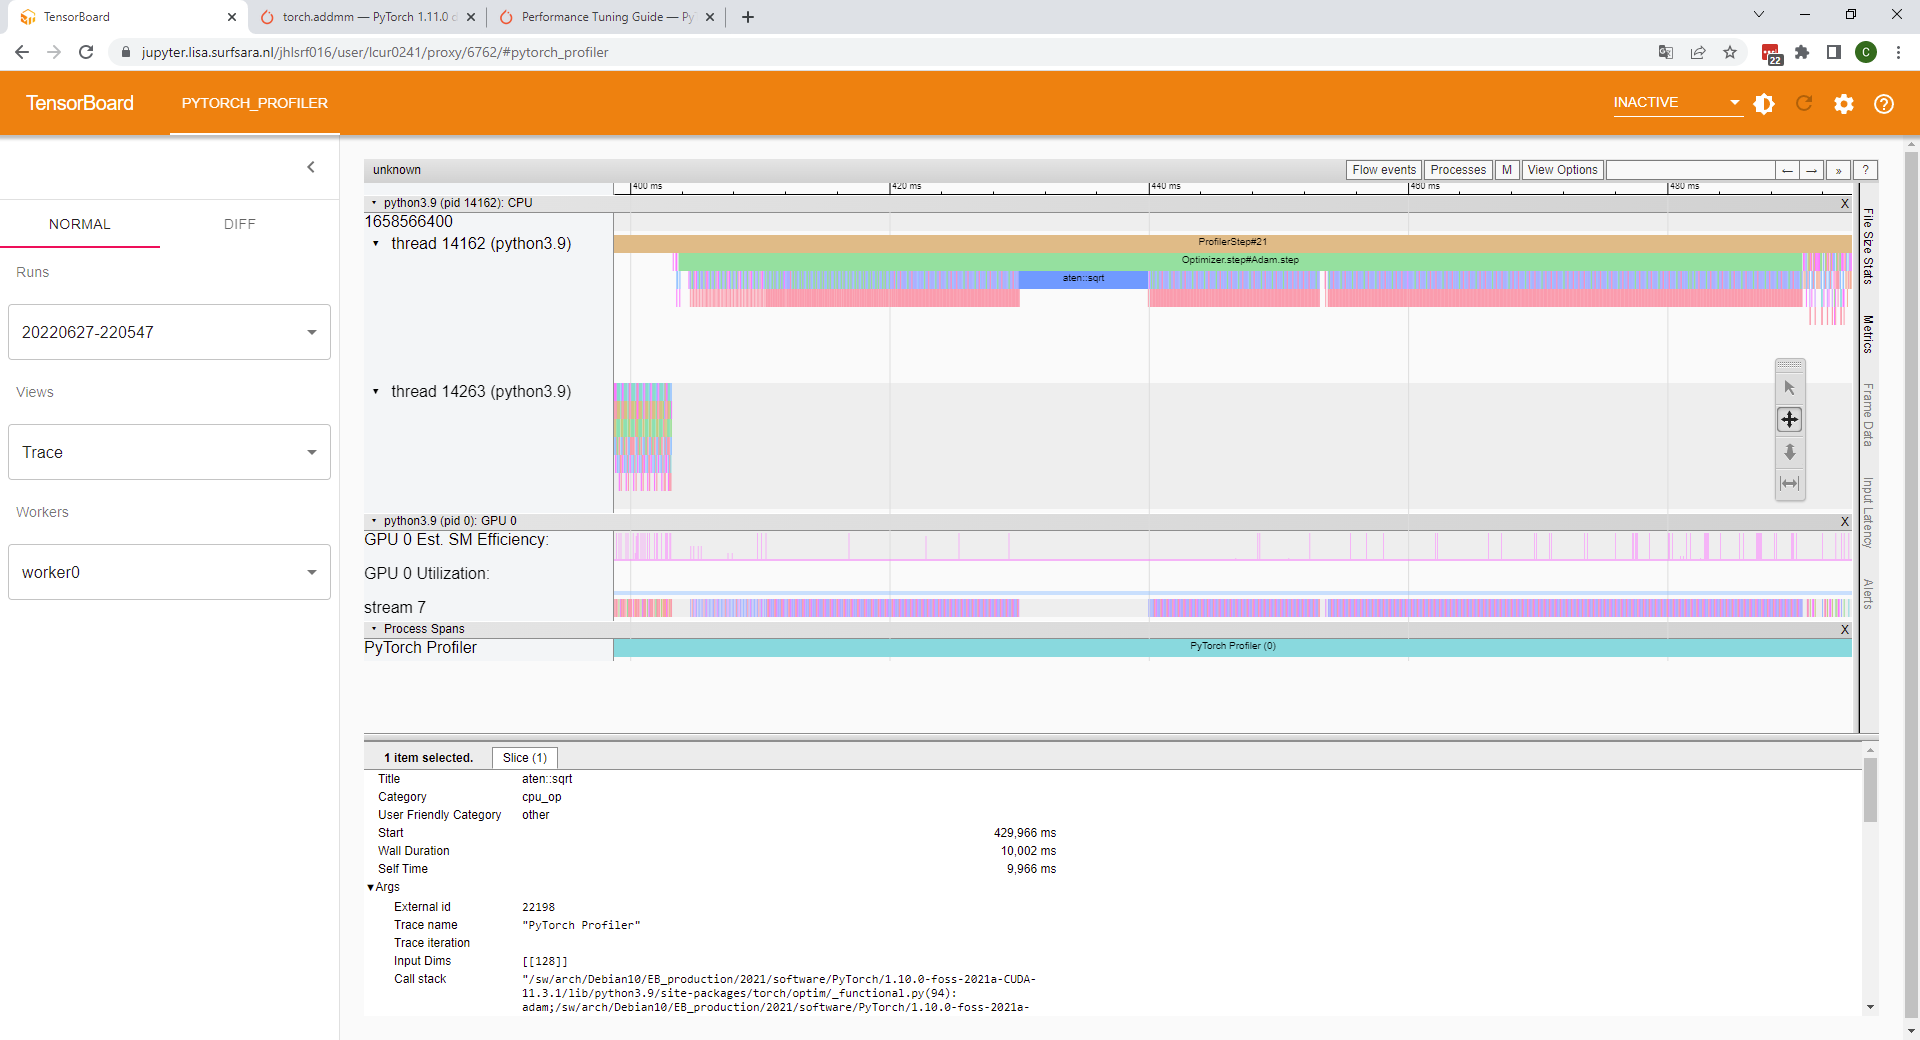